In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image
#%matplotlib inline


In [2]:
#图像保持比例放大或缩小
class PreprocessResizeKeepRatio(object):

    def __init__(self, width, height):
        self.width = width
        self.height = height

    def do(self, cv2_img):
        max_width = self.width
        max_height = self.height

        cur_height, cur_width = cv2_img.shape[:2]#当前图像尺寸

        ratio_w = float(max_width)/float(cur_width)
        ratio_h = float(max_height)/float(cur_height)
        ratio = min(ratio_w, ratio_h)

        new_size = (min(int(cur_width*ratio), max_width),
                    min(int(cur_height*ratio), max_height))

        new_size = (max(new_size[0], 1),
                    max(new_size[1], 1),)

        resized_img = cv2.resize(cv2_img, new_size)
        return resized_img

#取峰值
def extract_peek_ranges_from_array(array_vals, minimun_val=3, minimun_range=20):
    start_i = None
    end_i = None
    peek_ranges = []
    for i, val in enumerate(array_vals):
        if val > minimun_val and start_i is None:
            start_i = i
        elif val > minimun_val and start_i is not None:
            pass
        elif val < minimun_val and start_i is not None:
            end_i = i
            if end_i - start_i >= minimun_range:
                peek_ranges.append((start_i, end_i))
            start_i = None
            end_i = None
        elif val < minimun_val and start_i is None:
            pass
        else:
            raise ValueError("cannot parse this case...")
    return peek_ranges

## Try to find text lines and chars
def crop_direct(peek_ranges, debug = True):   
    vertical_peek_ranges2d = []
    for peek_range in peek_ranges:
        start_y = peek_range[0]
        end_y = peek_range[1]
        line_img = adaptive_image[start_y:end_y, :]
        vertical_sum = np.sum(line_img, axis=0)
        vertical_peek_ranges = extract_peek_ranges_from_array(
            vertical_sum,
            minimun_val=20,
            minimun_range=1)
        #vertical_peek_ranges = median_split_ranges(vertical_peek_ranges)#利用中位数再次切割
        if debug:           
            print(vertical_peek_ranges)
        vertical_peek_ranges2d.append(vertical_peek_ranges)
    return vertical_peek_ranges2d

class PreprocessCropZeros(object):#四个方向切一遍

    def __init__(self):
        pass

    def do(self, cv2_gray_img):
        height = cv2_gray_img.shape[0]
        width = cv2_gray_img.shape[1]

        v_sum = np.sum(cv2_gray_img, axis=0)
        h_sum = np.sum(cv2_gray_img, axis=1)
        left = 0
        right = width - 1
        top = 0
        low = height - 1

        for i in range(width):
            if v_sum[i] > 0:
                left = i
                break

        for i in range(width - 1, -1, -1):
            if v_sum[i] > 0:
                right = i
                break

        for i in range(height):
            if h_sum[i] > 0:
                top = i
                break

        for i in range(height - 1, -1, -1):
            if h_sum[i] > 0:
                low = i
                break
        if not (top < low and right > left):
            return cv2_gray_img

        return cv2_gray_img[top: low+1, left: right+1]

class PreprocessResizeKeepRatioFillBG(object):

    def __init__(self, width, height, fill_bg=False,
                 auto_avoid_fill_bg=True, margin=None):
        self.width = width
        self.height = height
        self.fill_bg = fill_bg
        self.auto_avoid_fill_bg = auto_avoid_fill_bg
        self.margin = margin

    @classmethod
    def is_need_fill_bg(cls, cv2_img, th=0.5, max_val=255):
        image_shape = cv2_img.shape
        height, width = image_shape
        if height * 3 < width:
            return True
        if width * 3 < height:
            return True
        return False

    @classmethod
    def put_img_into_center(cls, img_large, img_small, ):
        width_large = img_large.shape[1]
        height_large = img_large.shape[0]

        width_small = img_small.shape[1]
        height_small = img_small.shape[0]

        if width_large < width_small:
            raise ValueError("width_large <= width_small")
        if height_large < height_small:
            raise ValueError("height_large <= height_small")

        start_width = (width_large - width_small) / 2
        start_height = (height_large - height_small) / 2

        img_large[start_height:start_height + height_small,
                  start_width:start_width + width_small] = img_small
        return img_large

    def do(self, cv2_img):

        if self.margin is not None:
            width_minus_margin = max(2, self.width - self.margin)
            height_minus_margin = max(2, self.height - self.margin)
        else:
            width_minus_margin = self.width
            height_minus_margin = self.height

        cur_height, cur_width = cv2_img.shape[:2]
        if len(cv2_img.shape) > 2:
            pix_dim = cv2_img.shape[2]
        else:
            pix_dim = None

        preprocess_resize_keep_ratio = PreprocessResizeKeepRatio(
            width_minus_margin,
            height_minus_margin)
        resized_cv2_img = preprocess_resize_keep_ratio.do(cv2_img)

        if self.auto_avoid_fill_bg:
            need_fill_bg = self.is_need_fill_bg(cv2_img)
            if not need_fill_bg:
                self.fill_bg = False
            else:
                self.fill_bg = True

        ## should skip horizontal stroke
        if not self.fill_bg:
            ret_img = cv2.resize(resized_cv2_img, (width_minus_margin,
                                                   height_minus_margin))
        else:
            if pix_dim is not None:
                norm_img = np.zeros((height_minus_margin,
                                     width_minus_margin,
                                     pix_dim),
                                    np.uint8)
            else:
                norm_img = np.zeros((height_minus_margin,
                                     width_minus_margin),
                                    np.uint8)
            ret_img = self.put_img_into_center(norm_img, resized_cv2_img)

        if self.margin is not None:
            if pix_dim is not None:
                norm_img = np.zeros((self.height,
                                     self.width,
                                     pix_dim),
                                    np.uint8)
            else:
                norm_img = np.zeros((self.height,
                                     self.width),
                                    np.uint8)
            ret_img = self.put_img_into_center(norm_img, ret_img)
        return ret_img



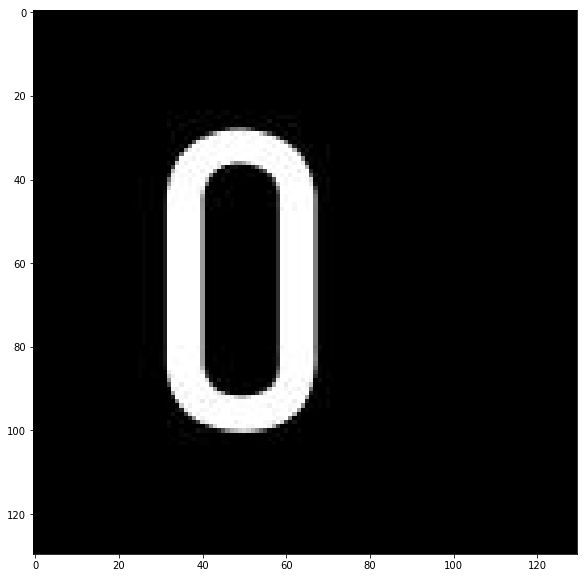

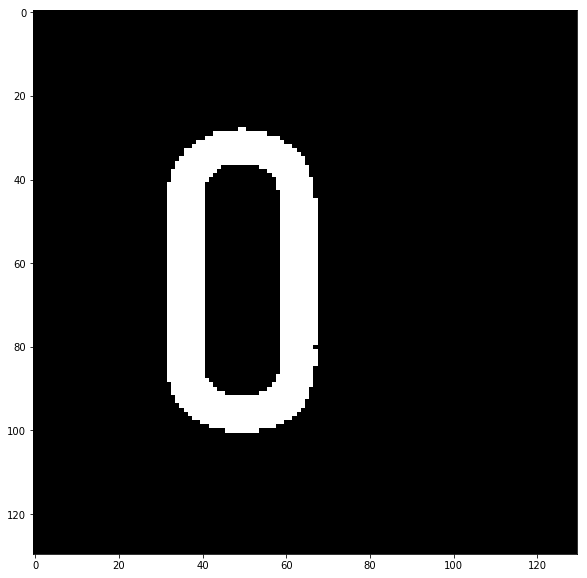

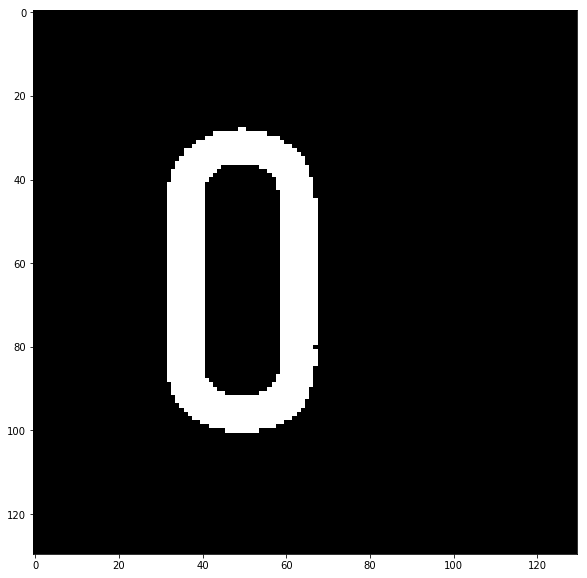

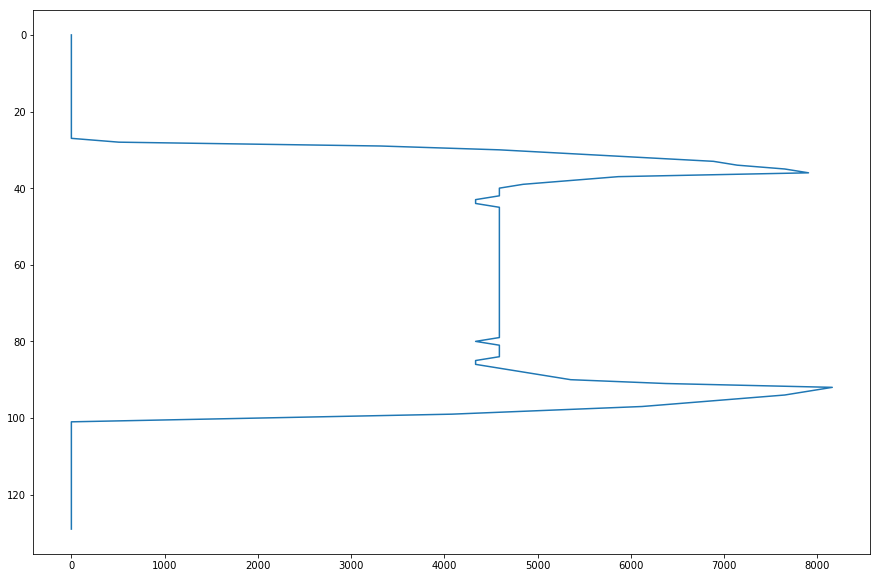

(1, 64, 64)


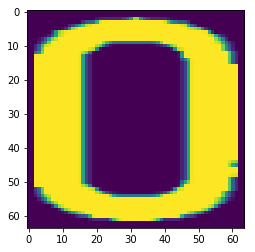

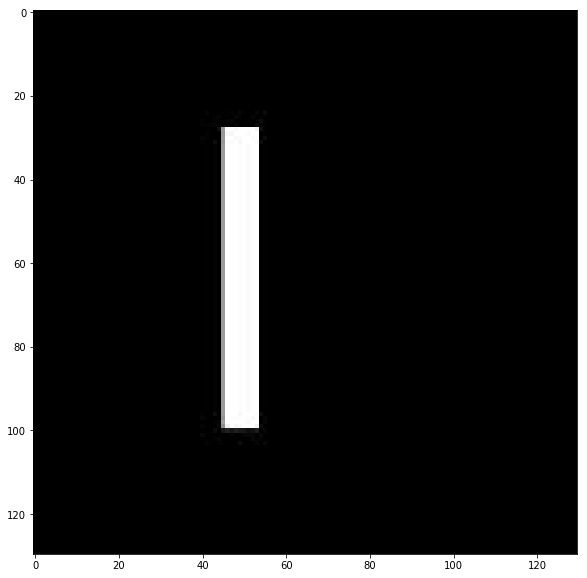

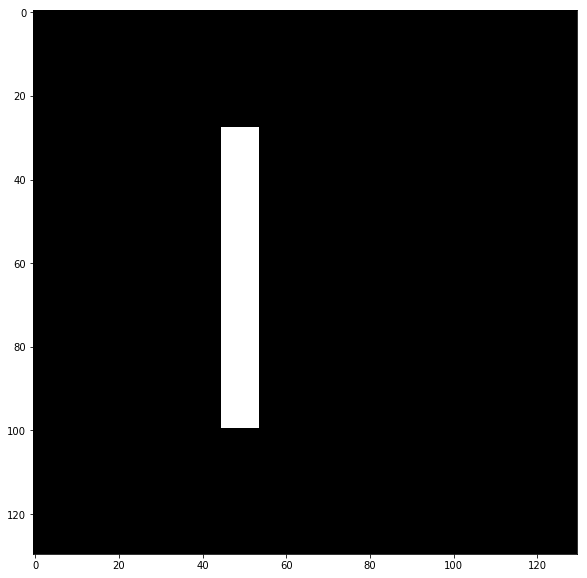

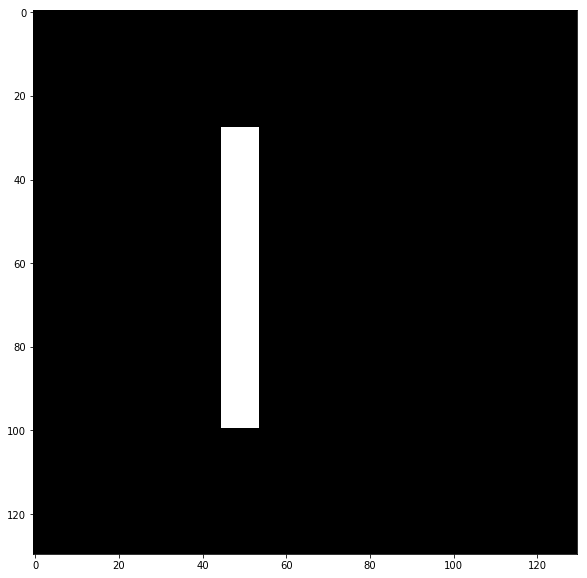

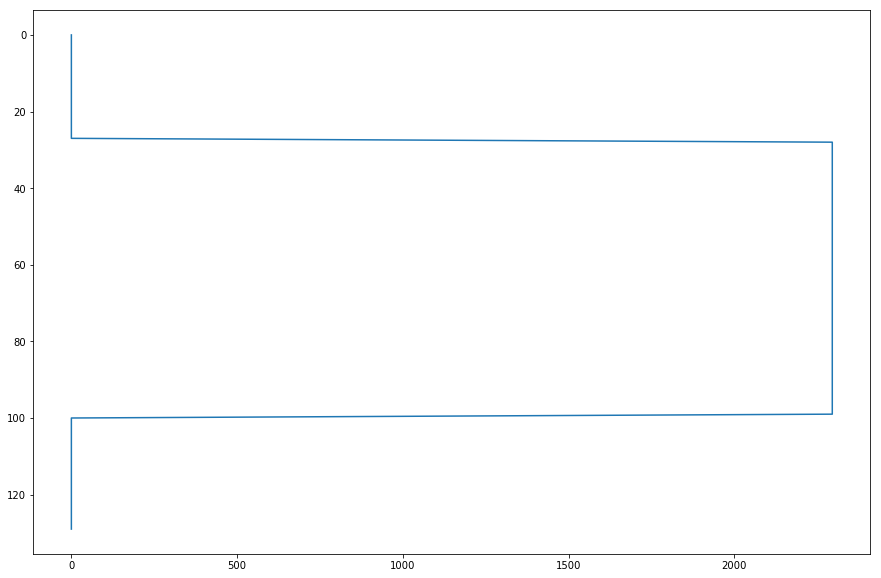

(1, 64, 64)


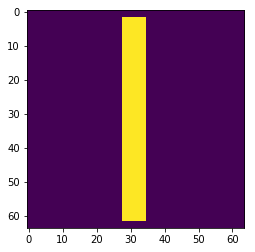

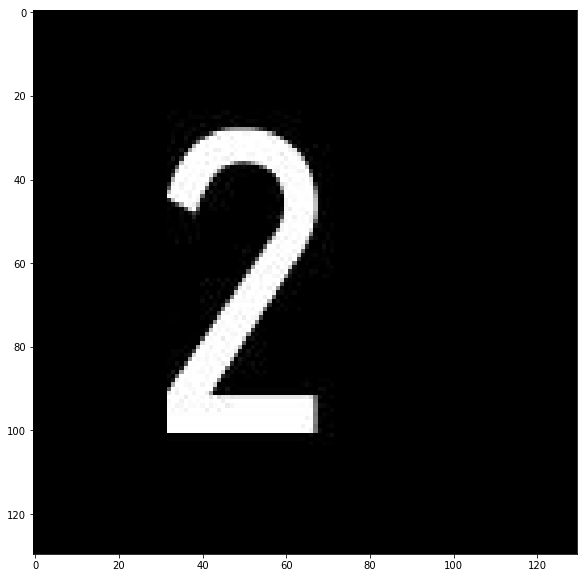

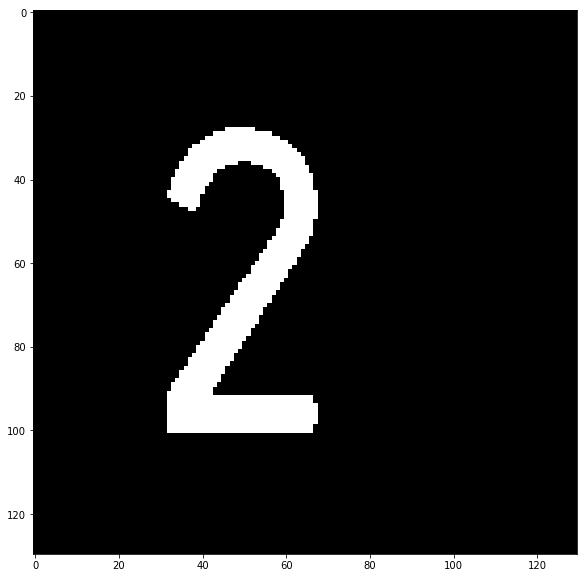

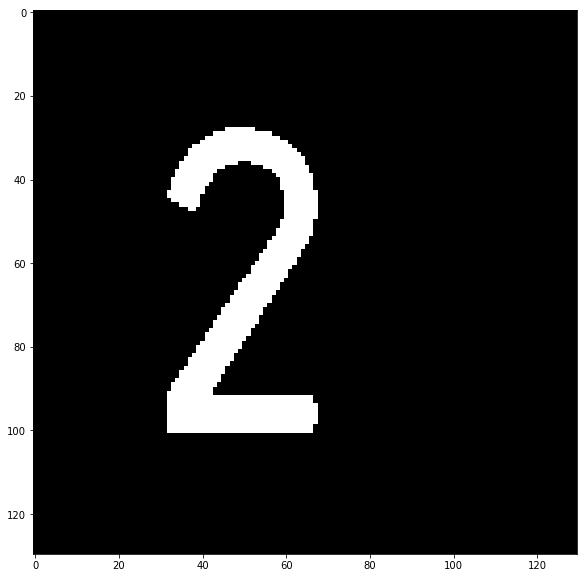

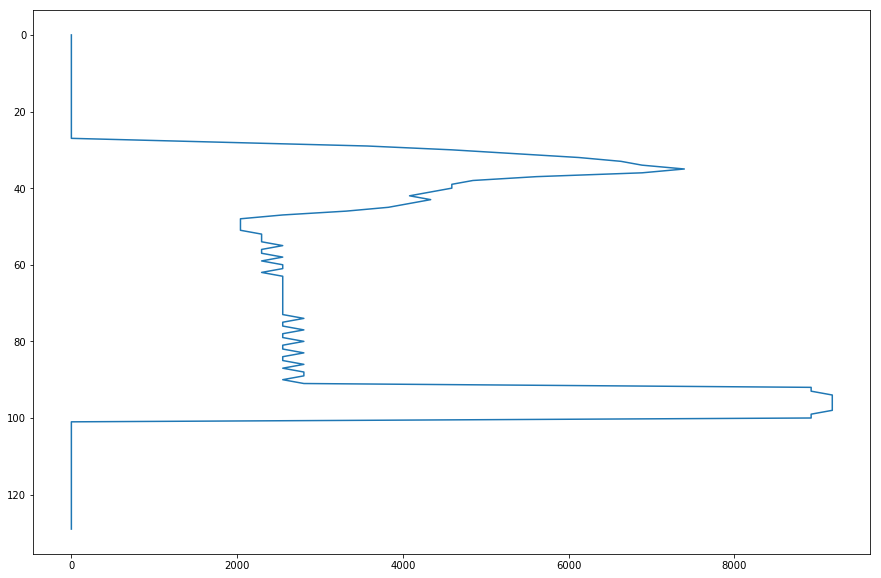

(1, 64, 64)


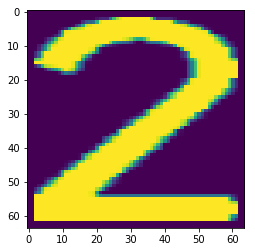

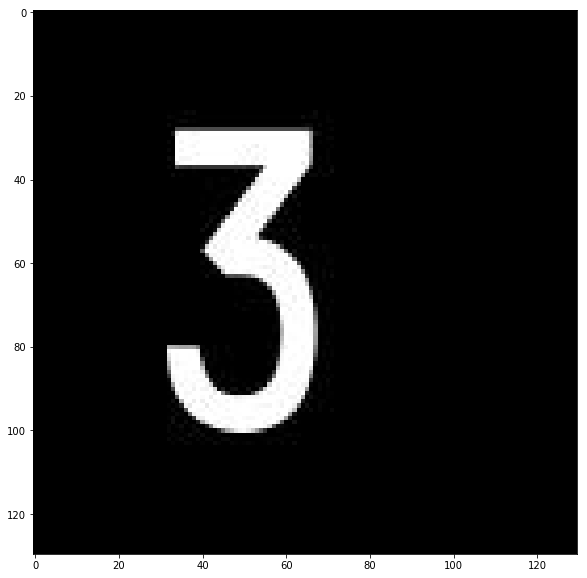

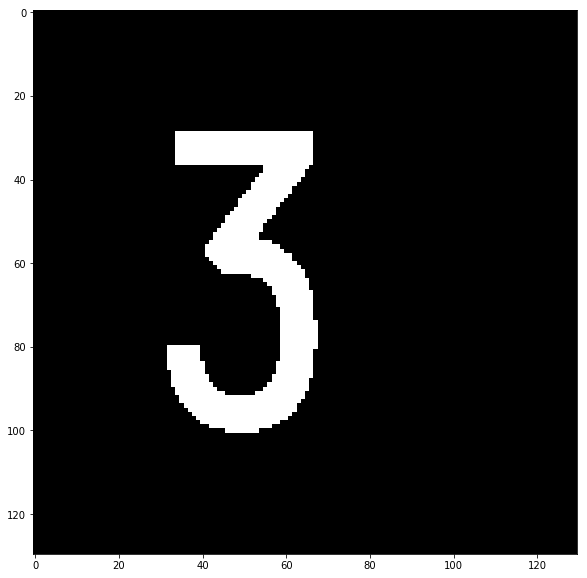

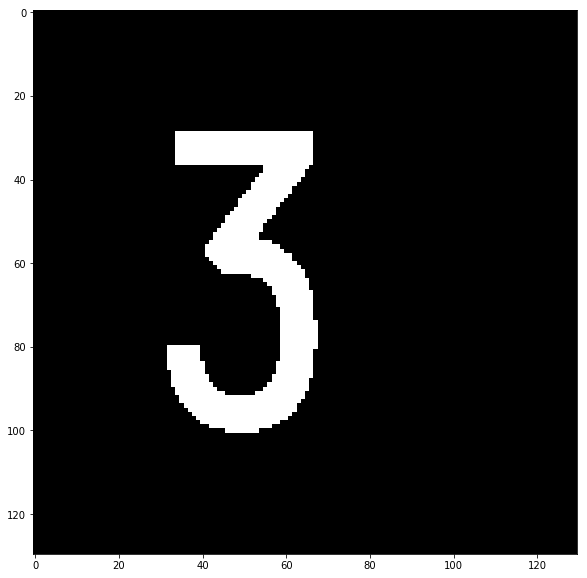

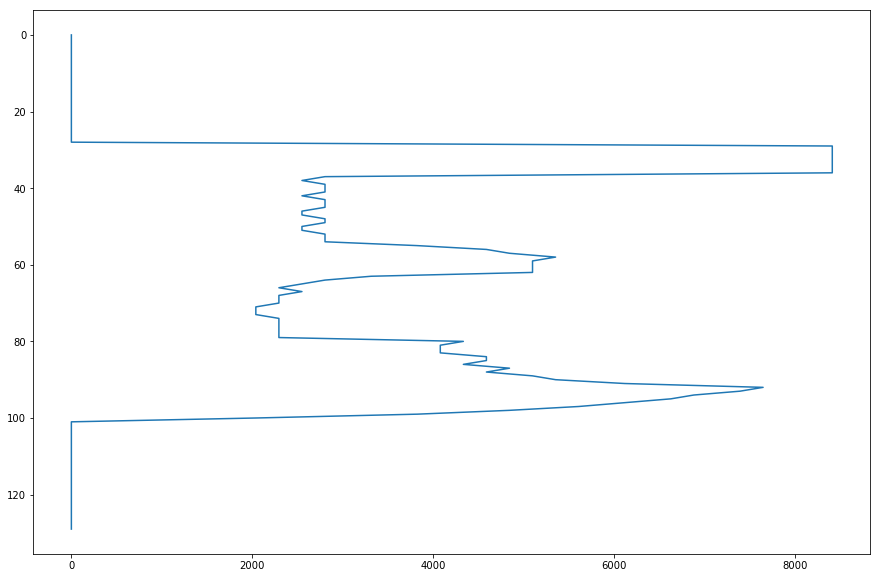

(1, 64, 64)


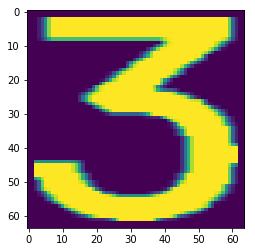

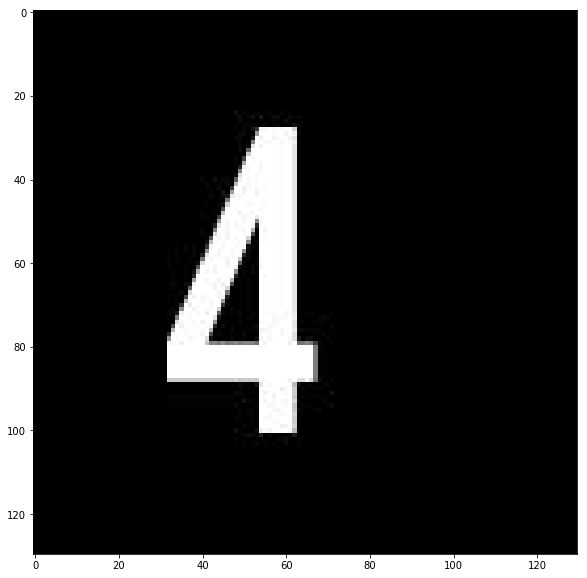

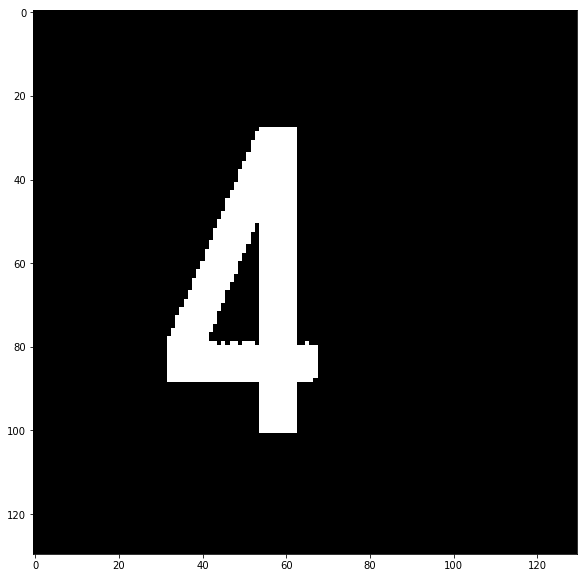

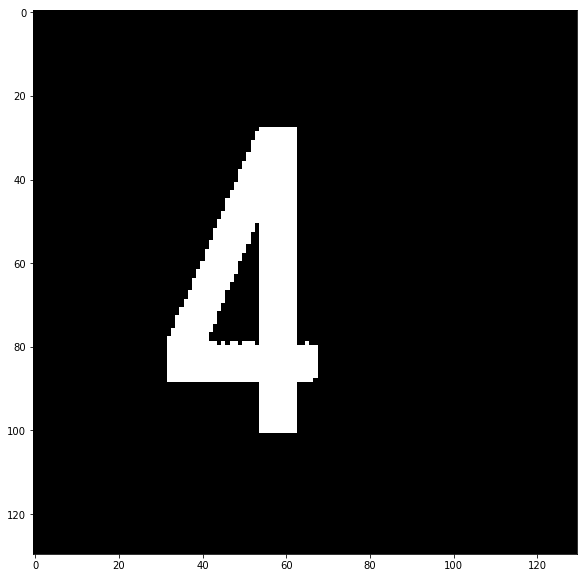

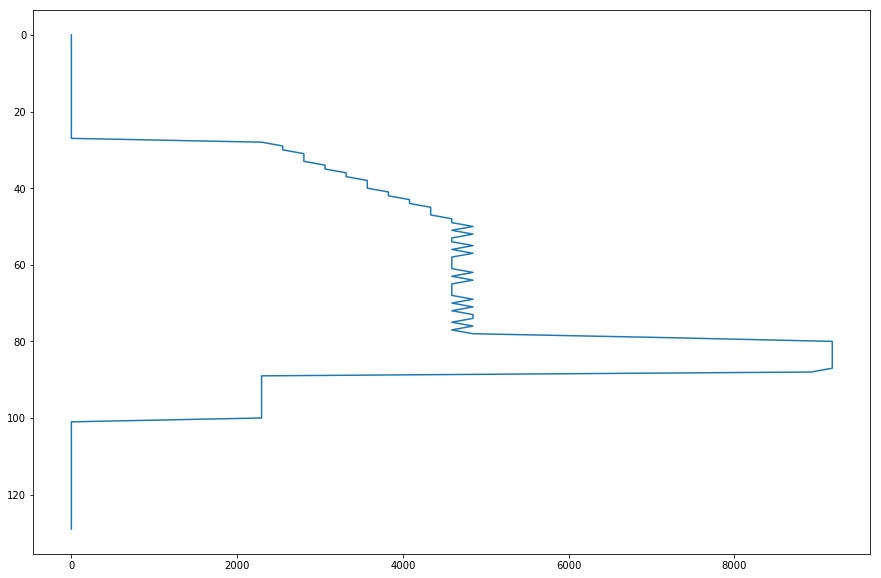

(1, 64, 64)


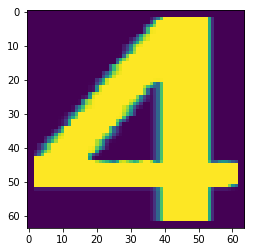

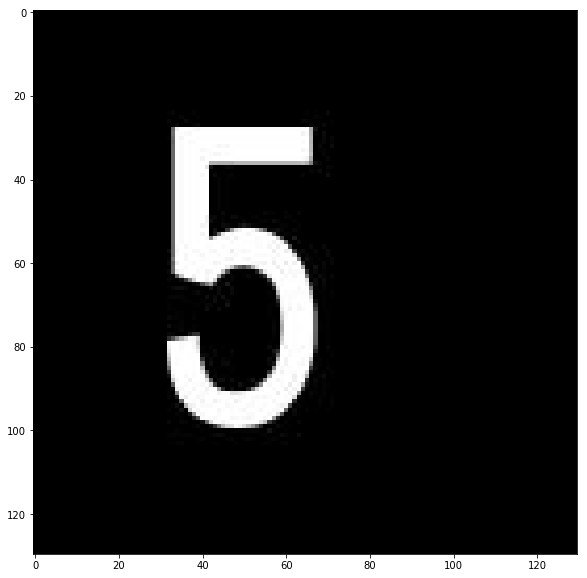

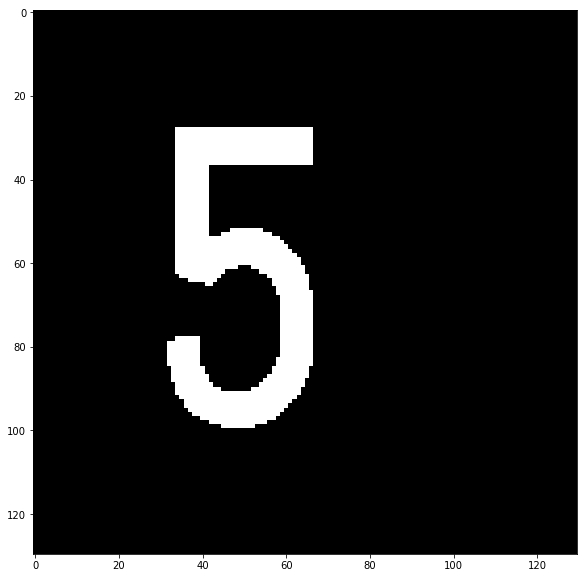

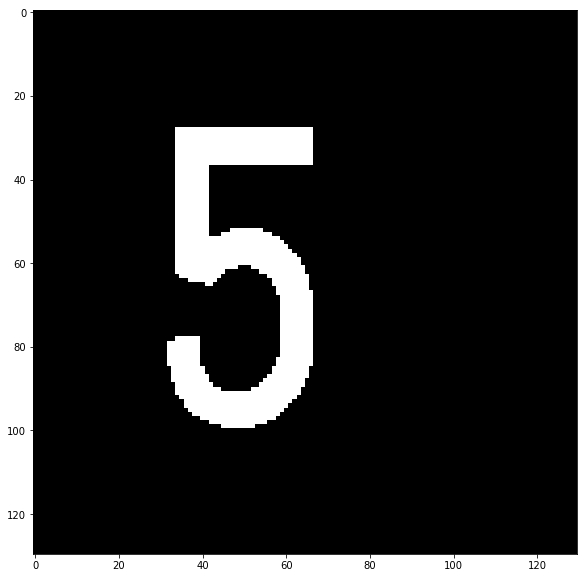

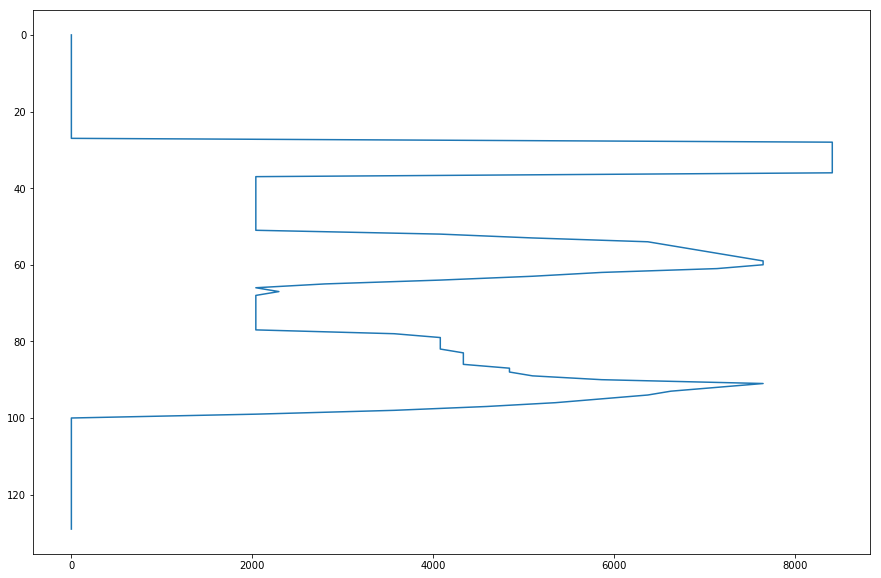

(1, 64, 64)


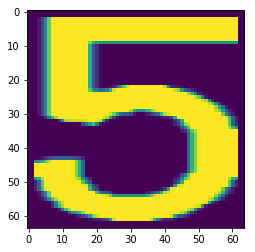

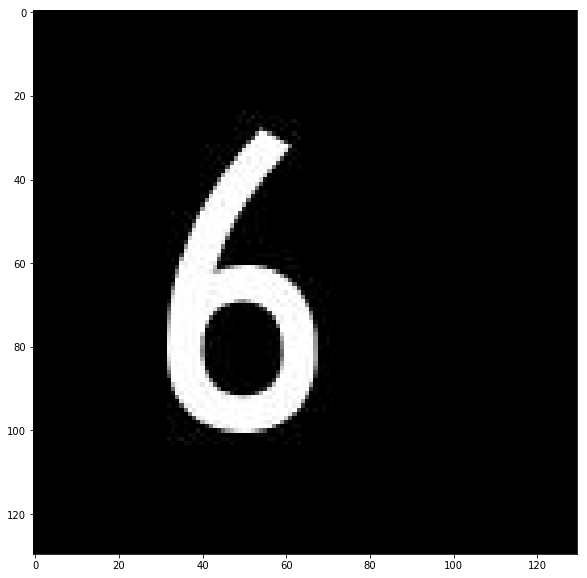

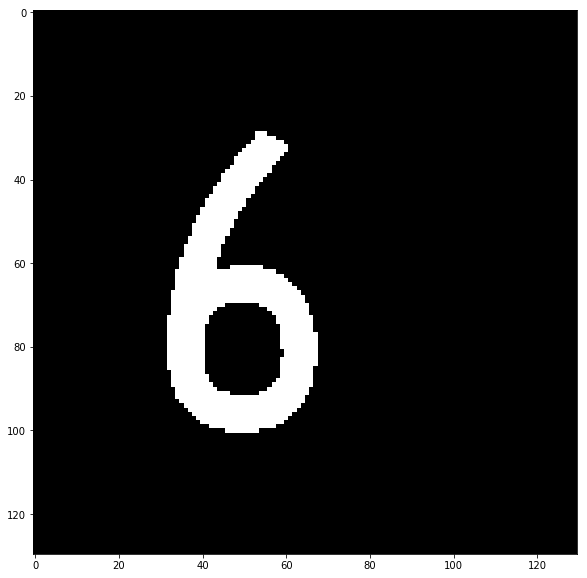

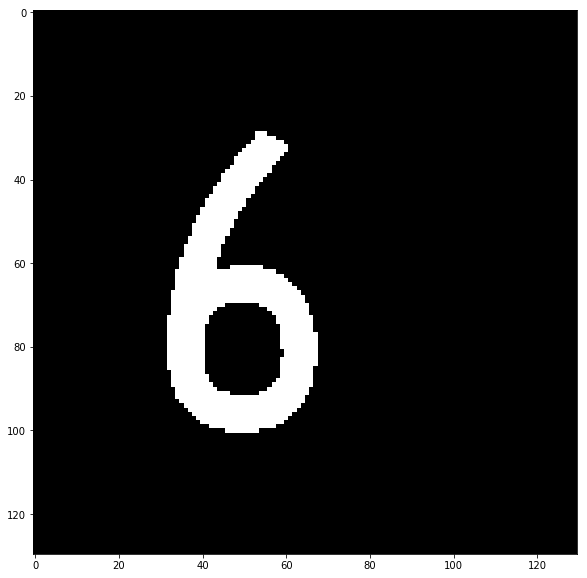

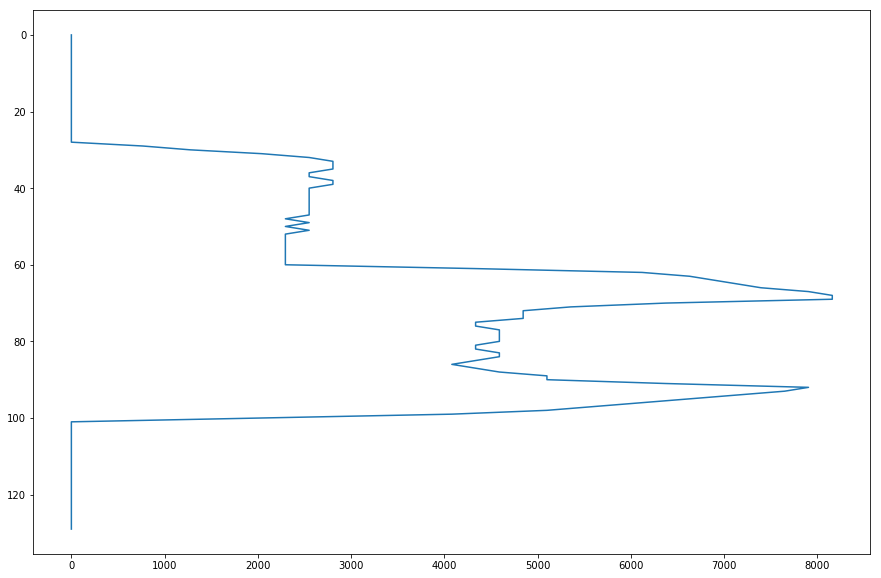

(1, 64, 64)


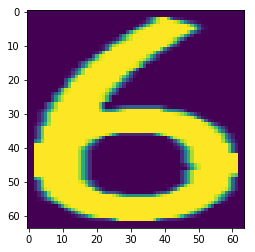

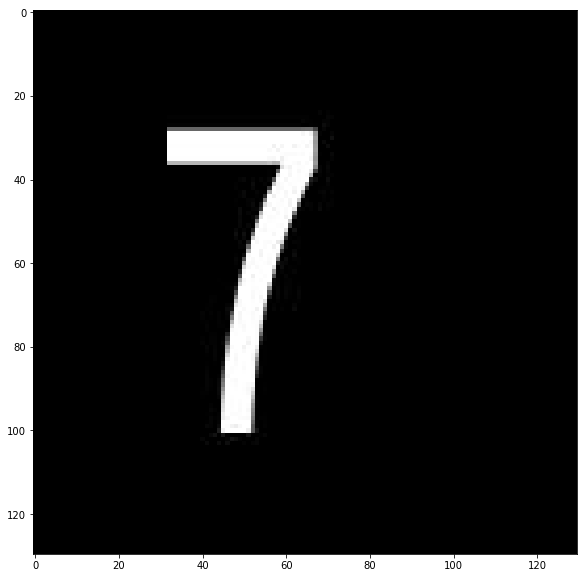

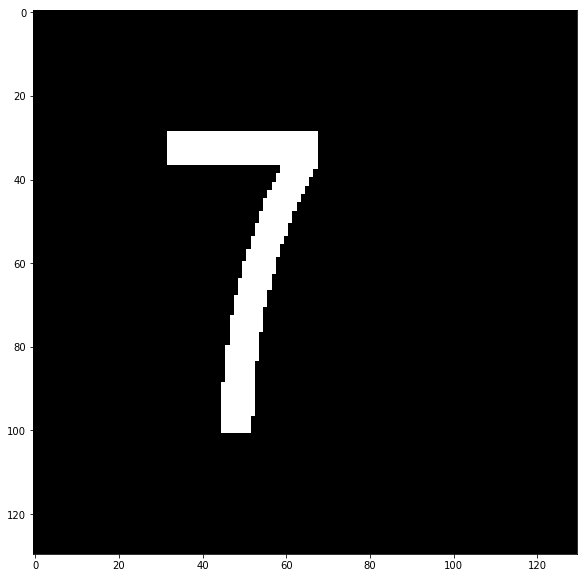

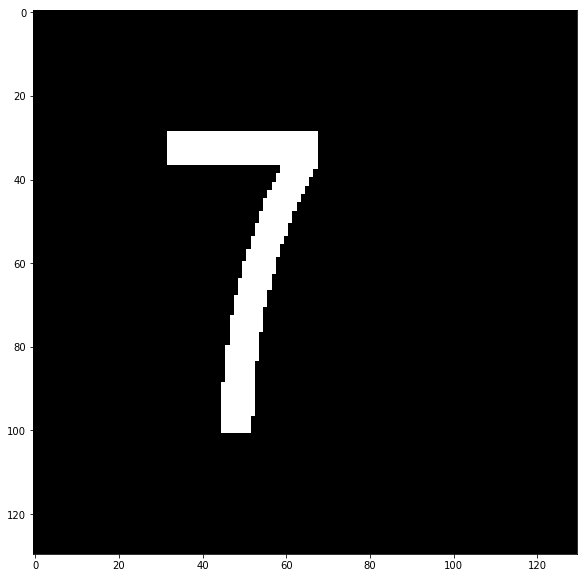

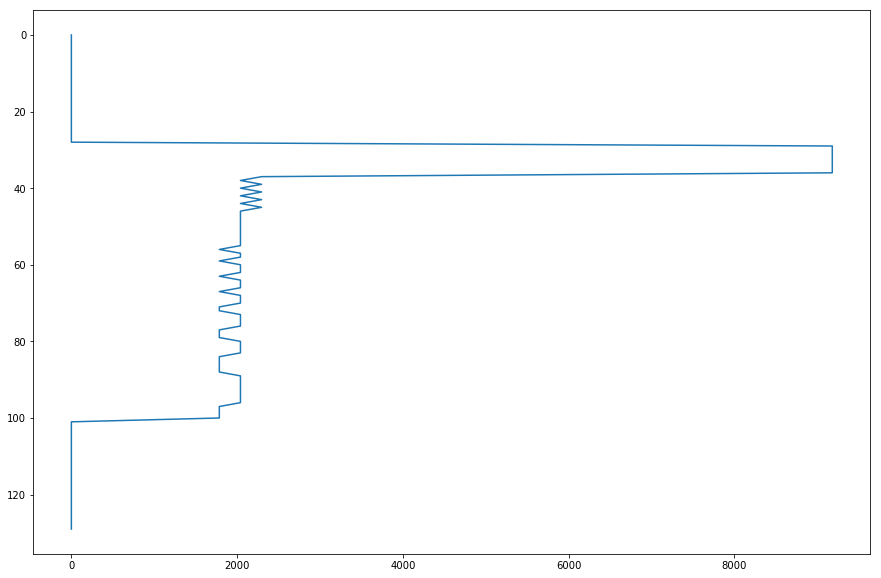

(1, 64, 64)


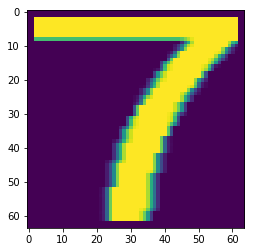

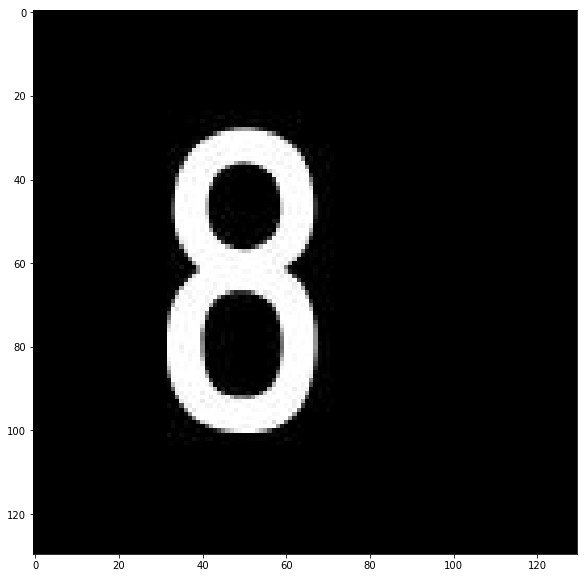

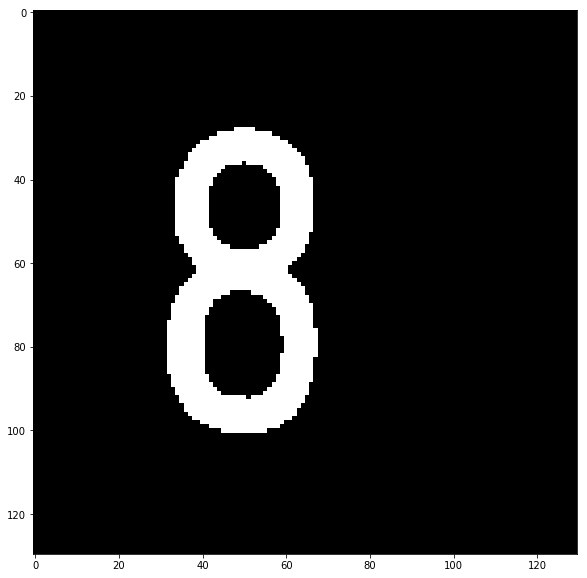

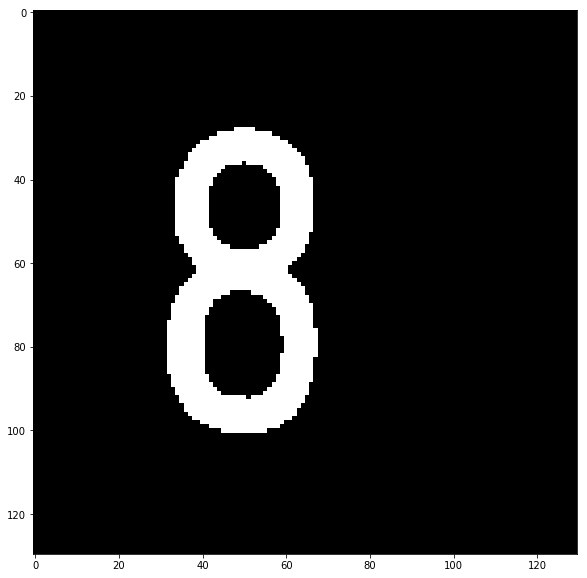

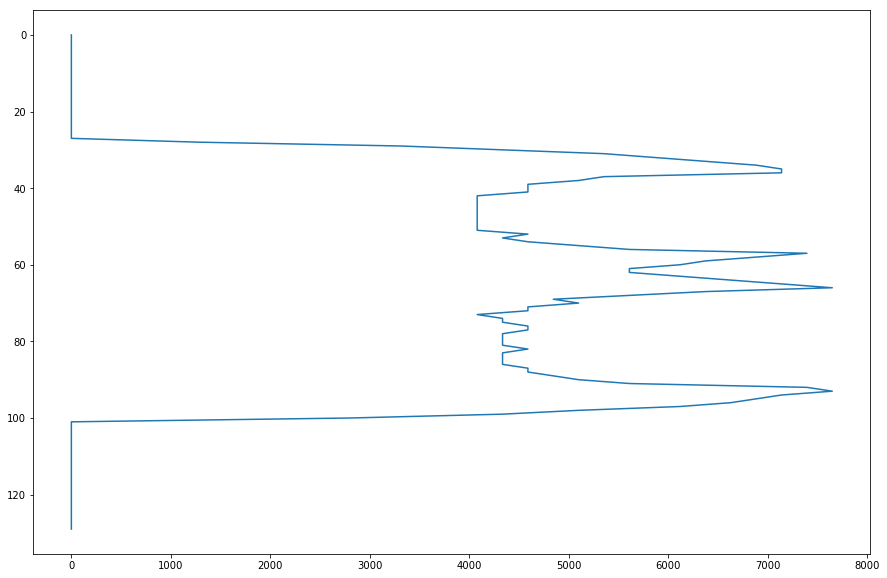

(1, 64, 64)


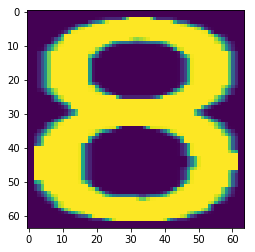

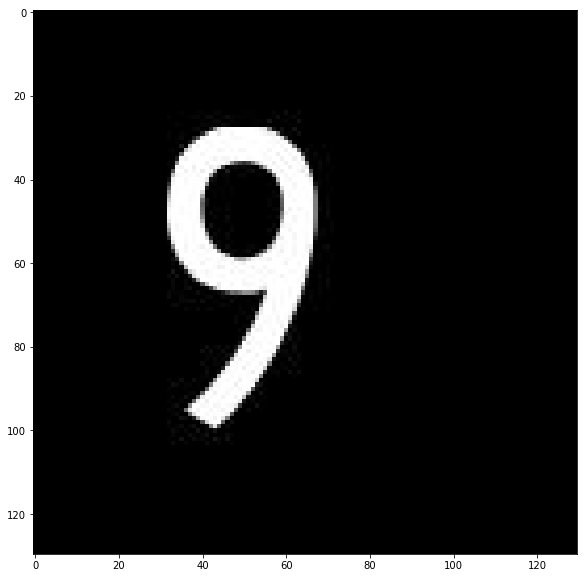

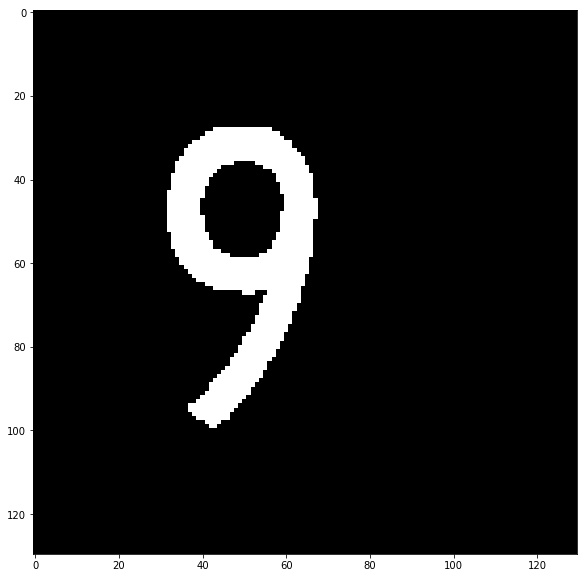

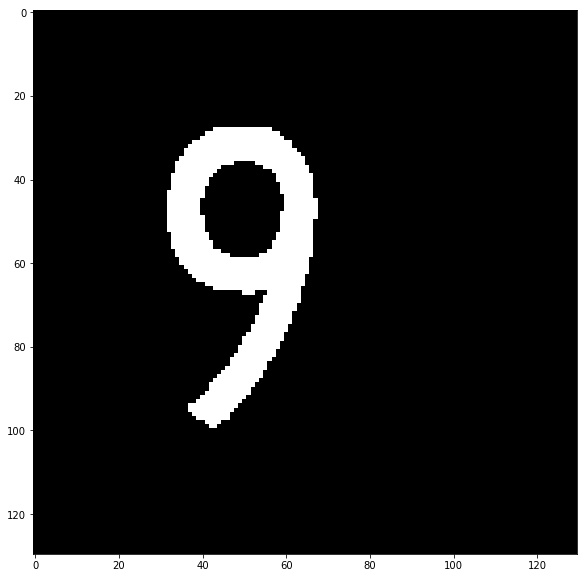

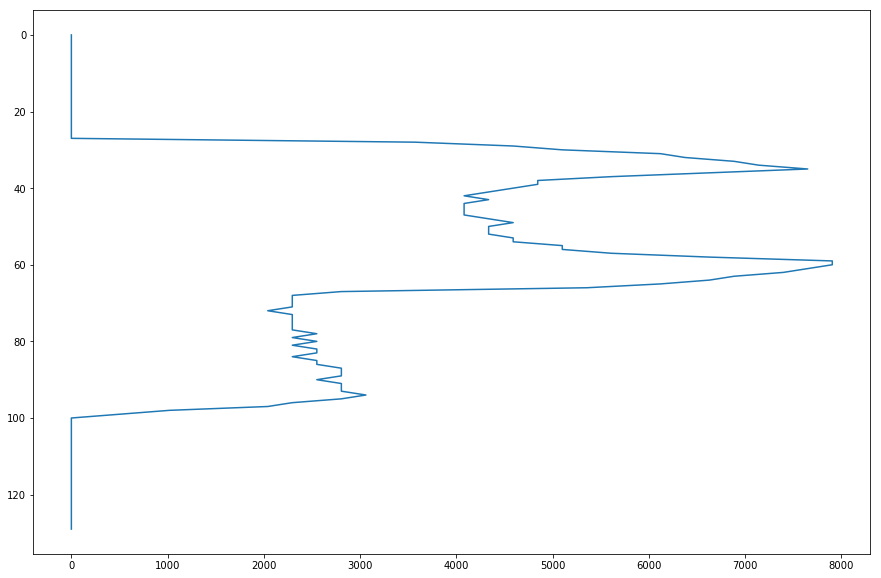

(1, 64, 64)


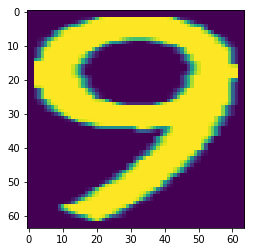

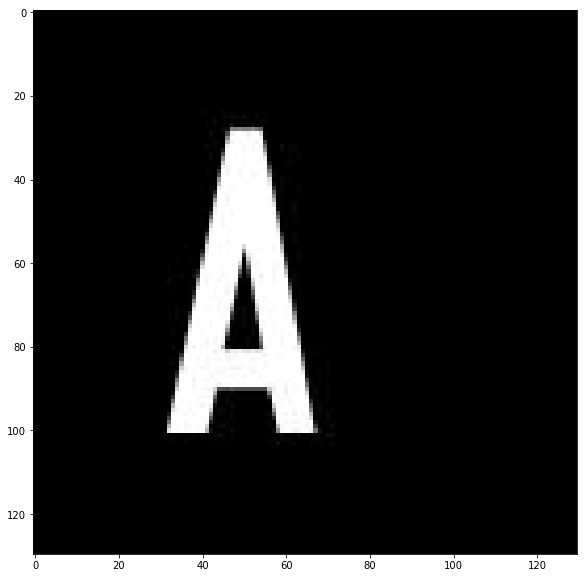

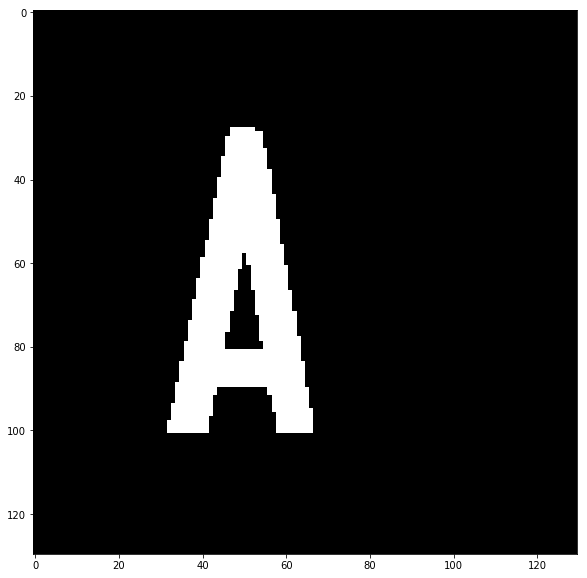

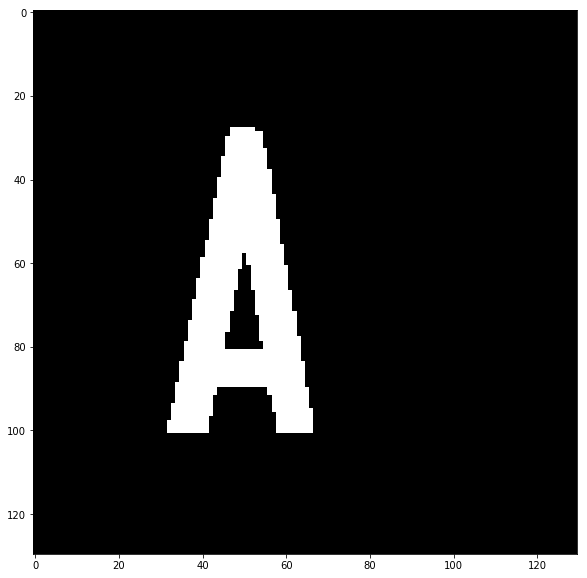

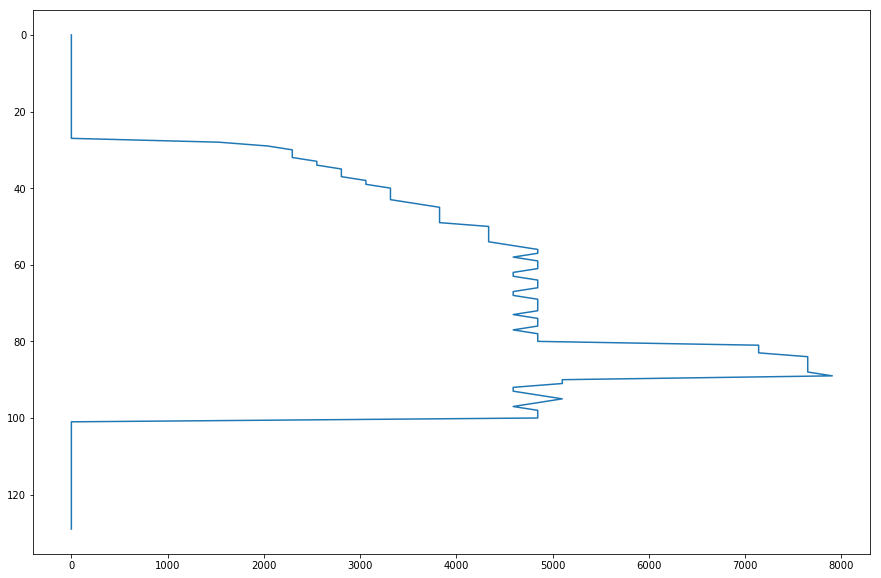

(1, 64, 64)


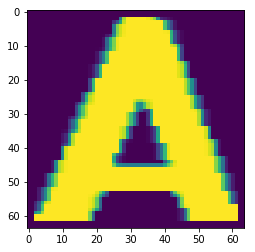

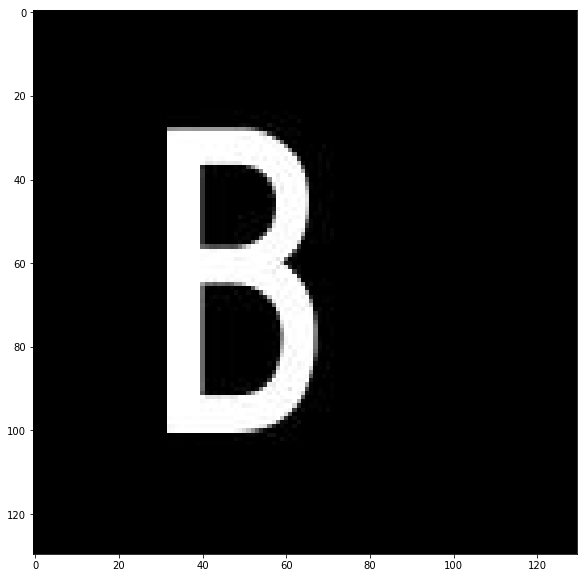

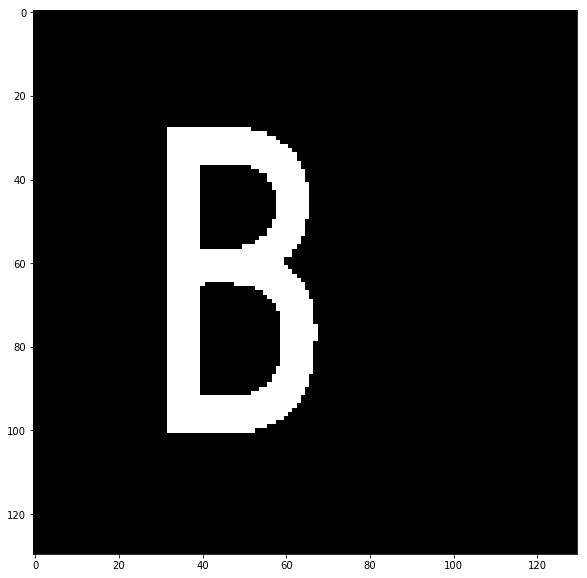

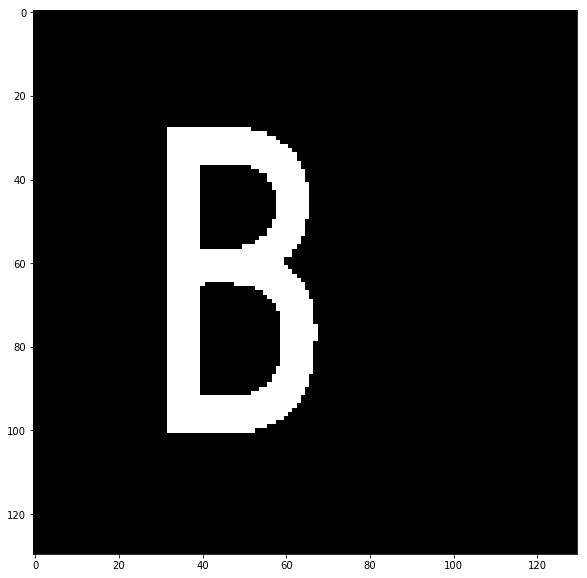

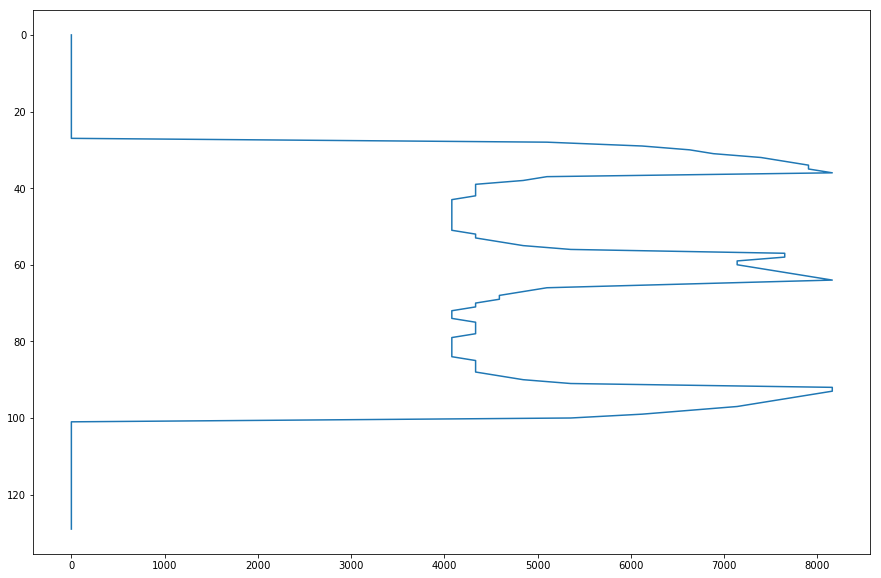

(1, 64, 64)


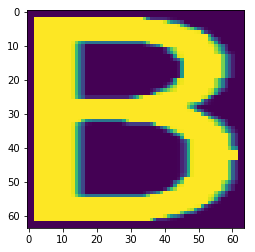

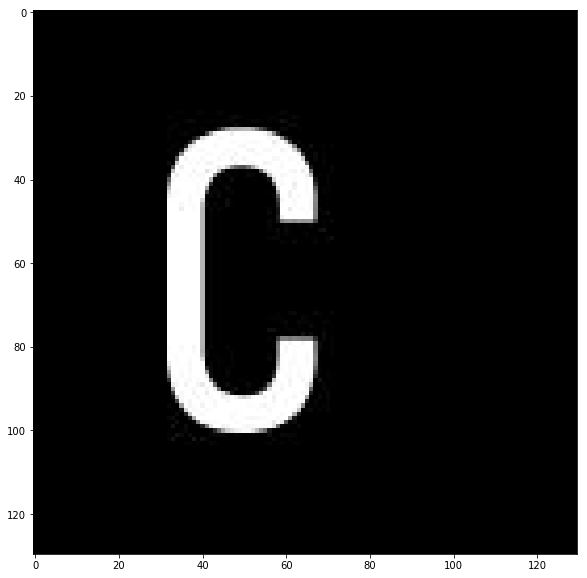

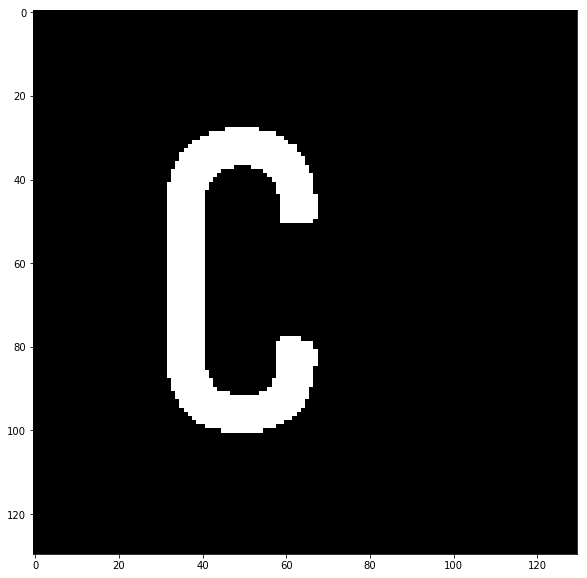

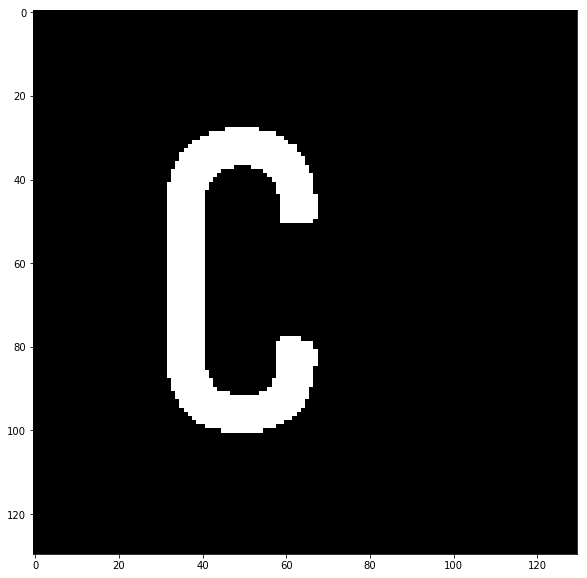

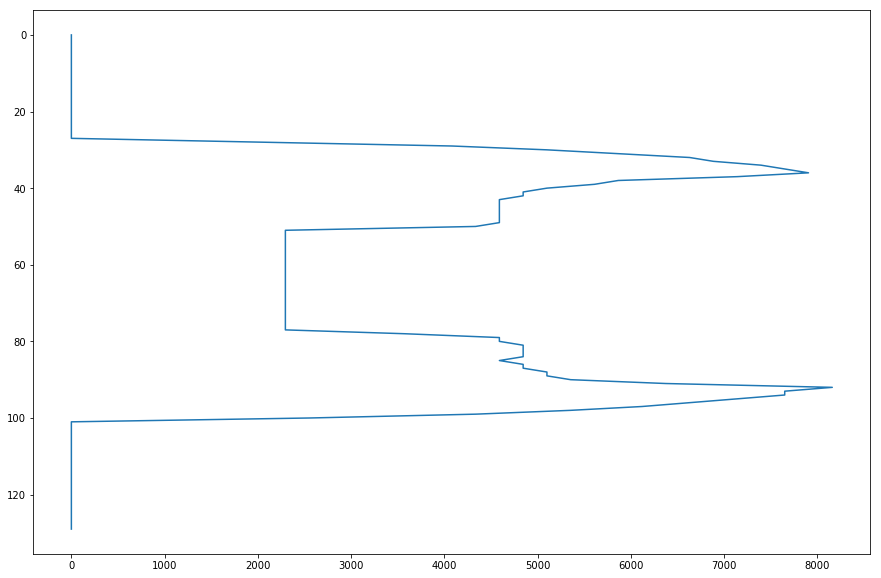

(1, 64, 64)


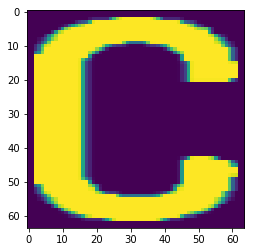

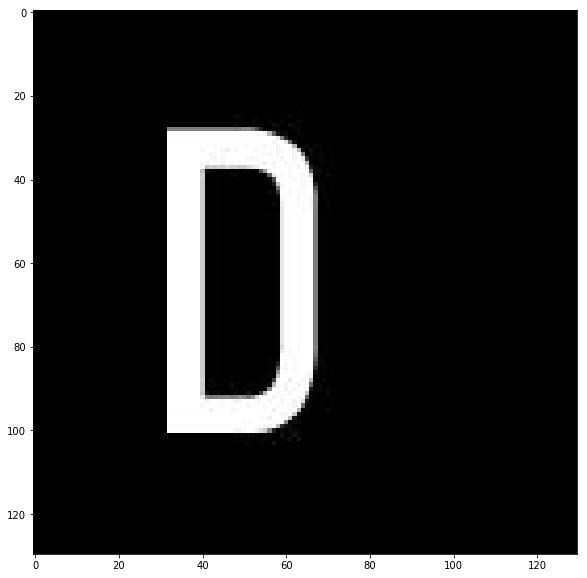

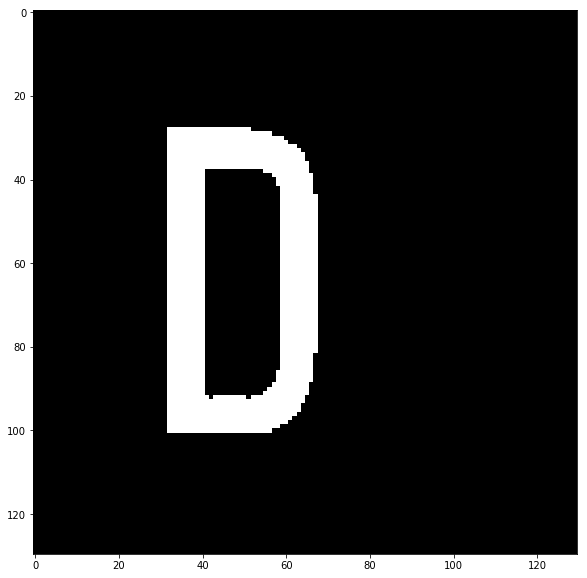

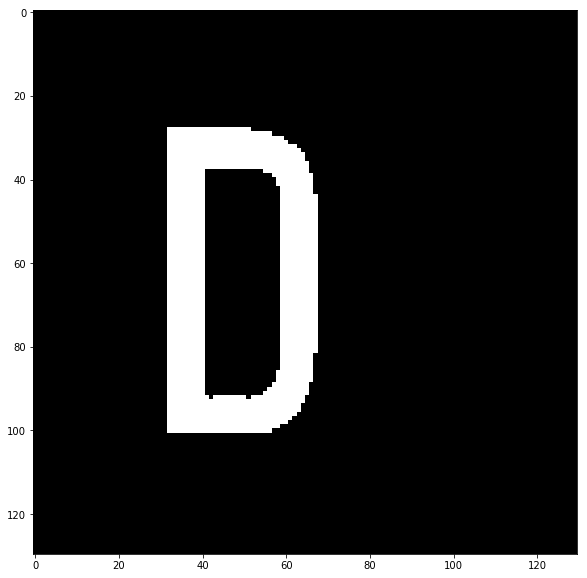

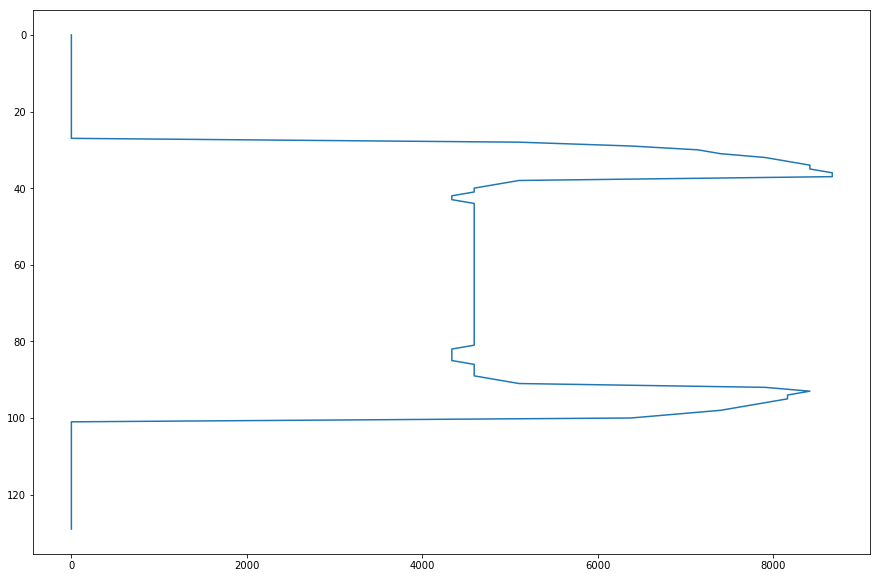

(1, 64, 64)


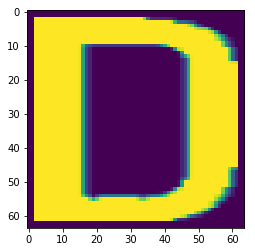

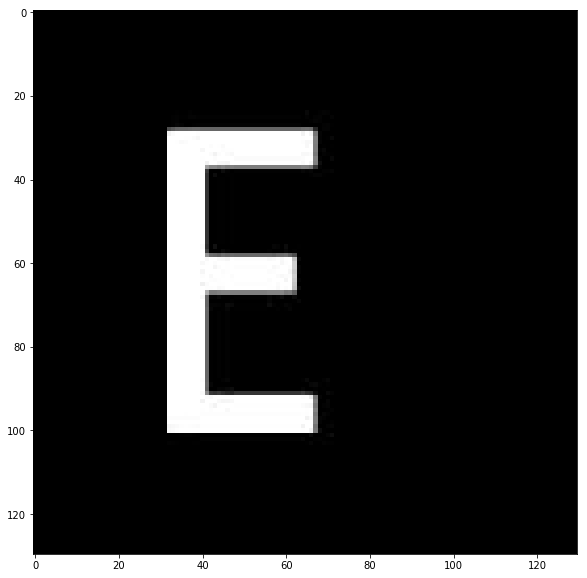

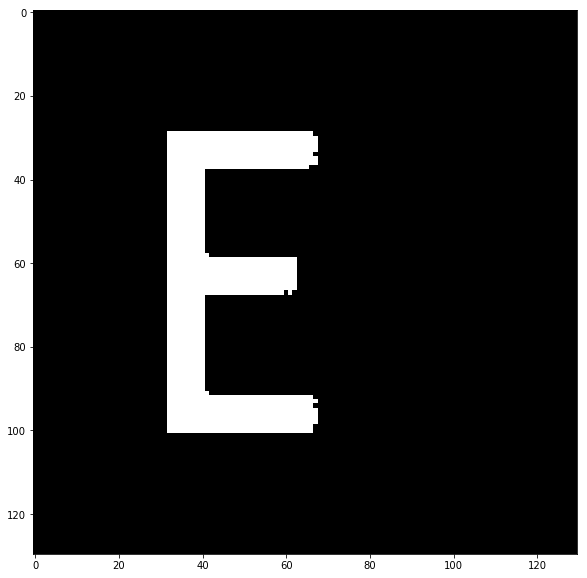

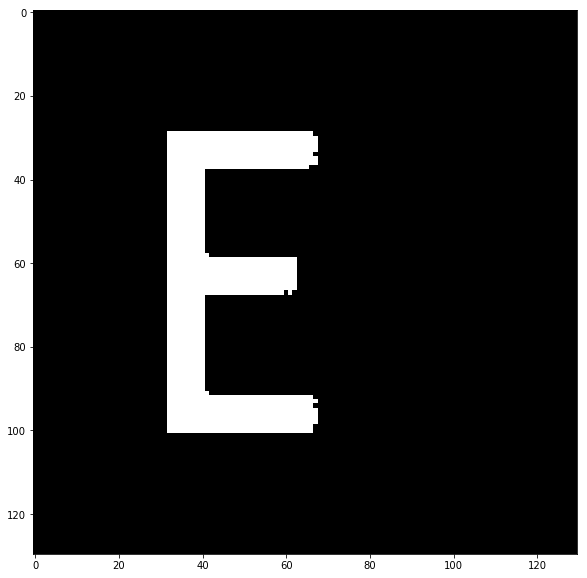

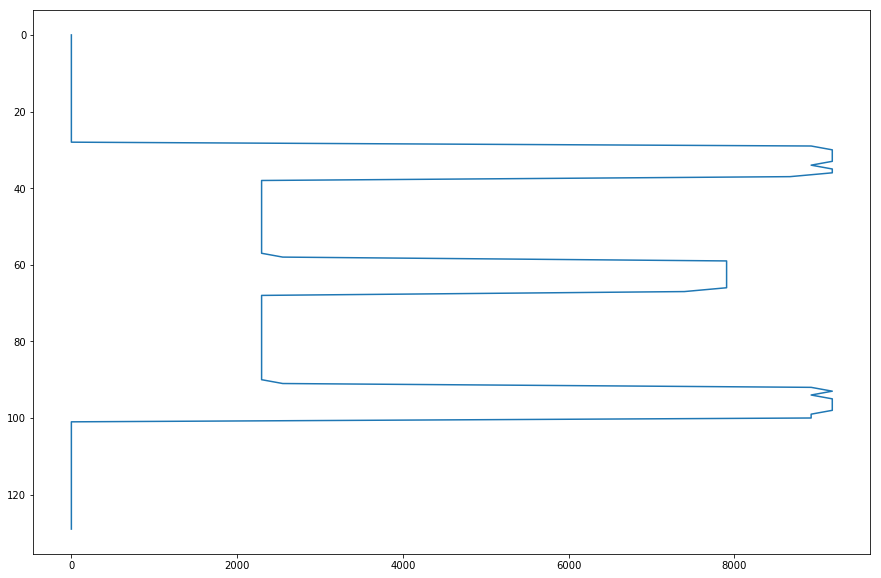

(1, 64, 64)


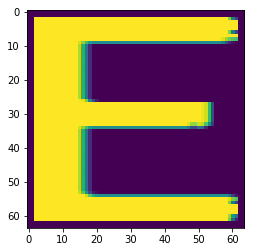

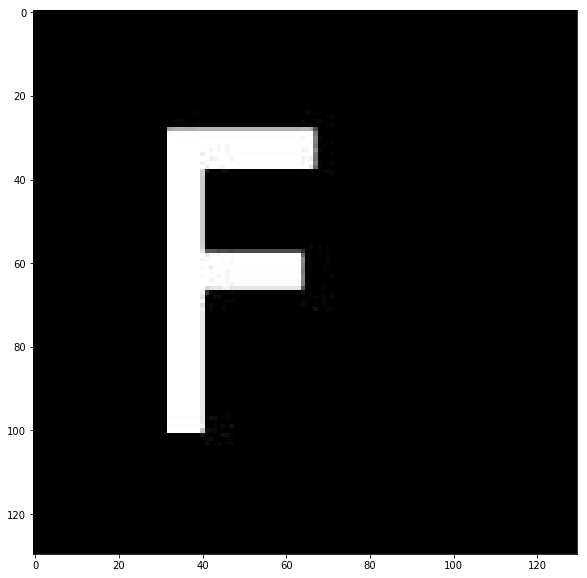

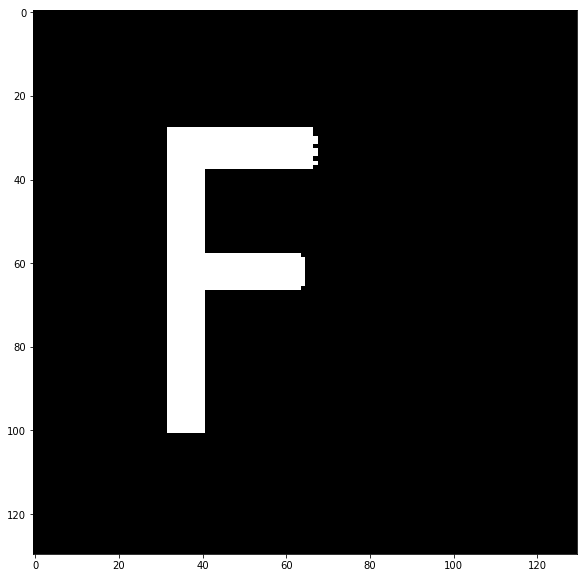

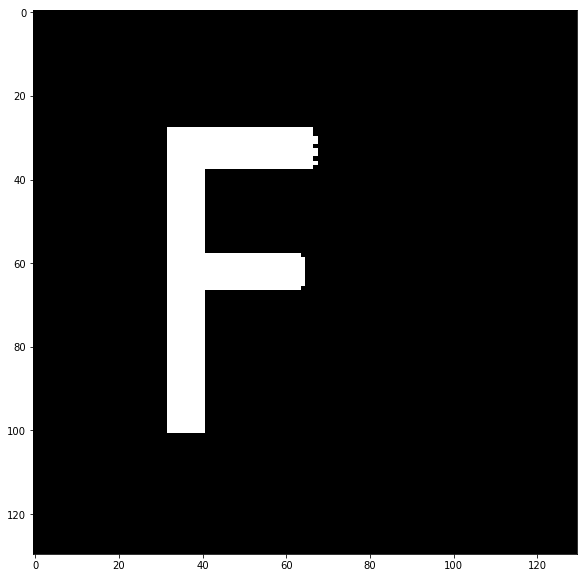

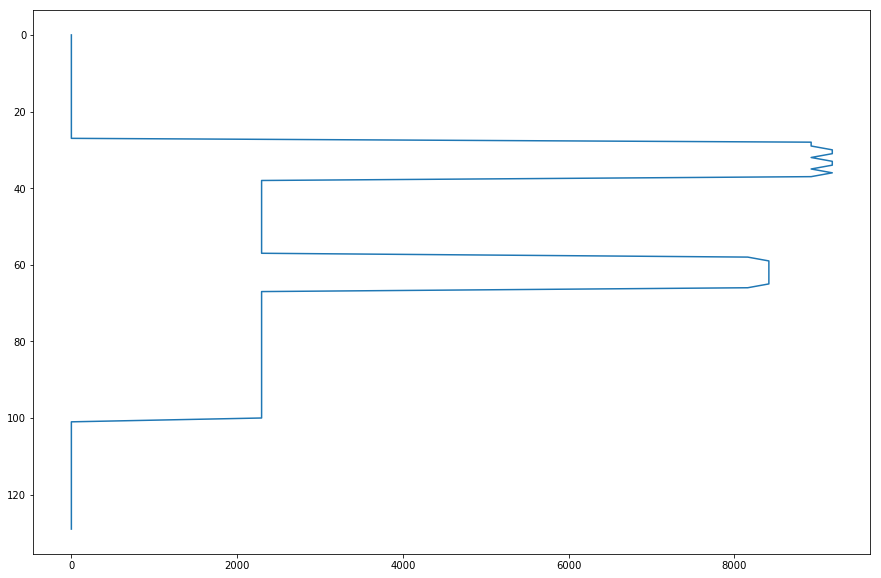

(1, 64, 64)


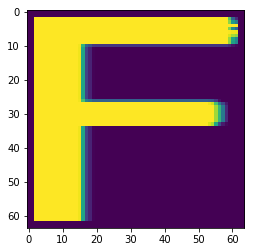

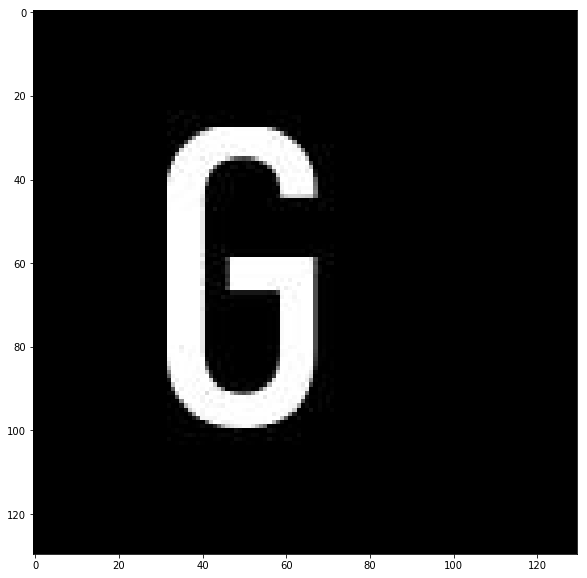

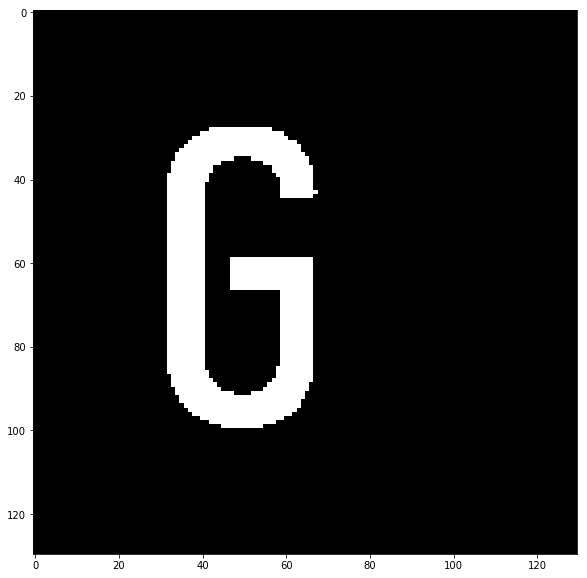

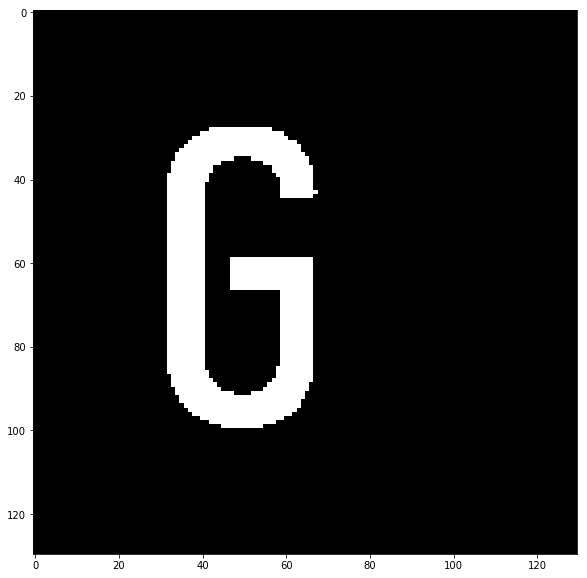

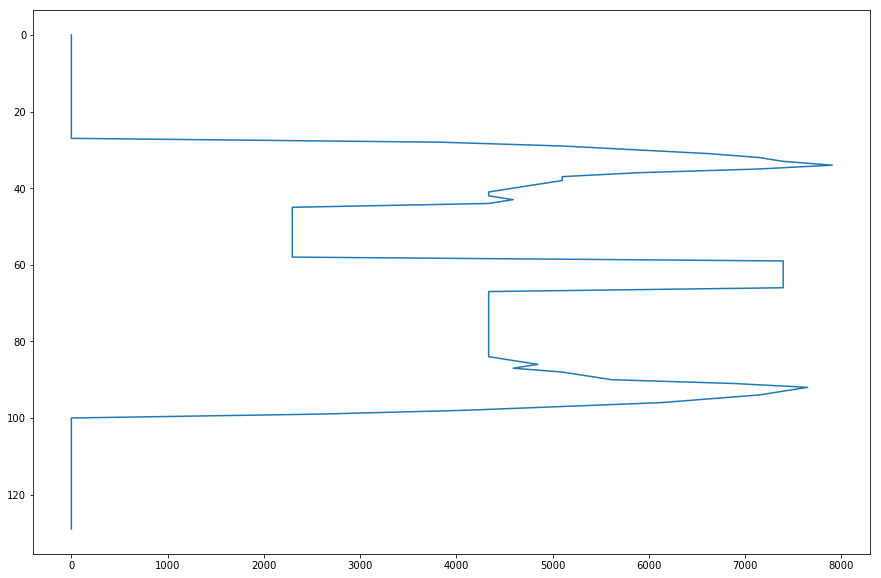

(1, 64, 64)


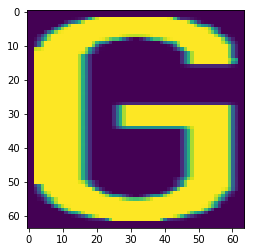

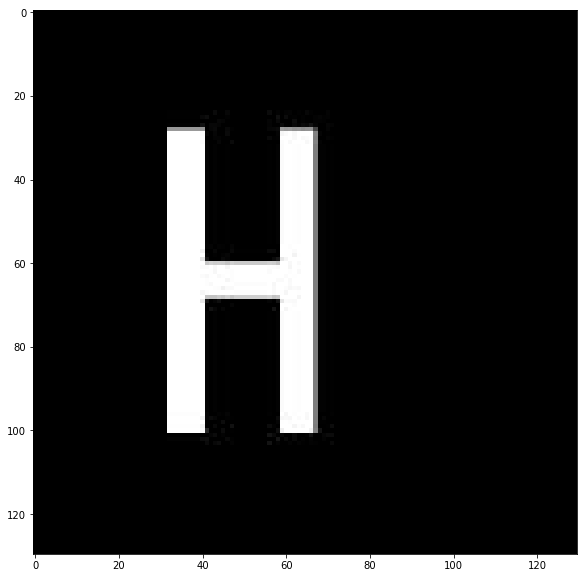

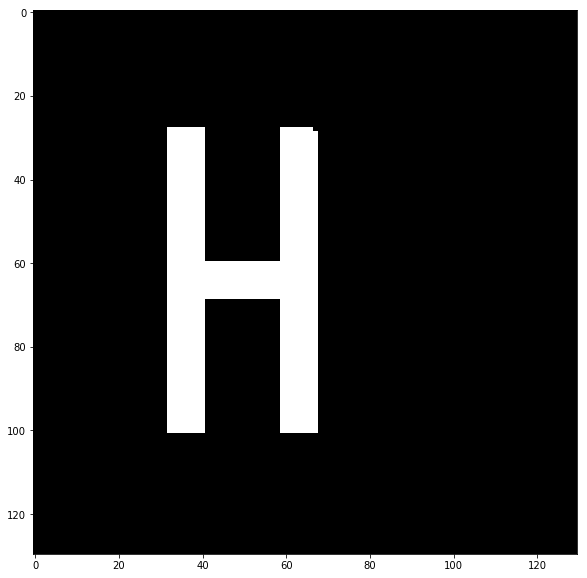

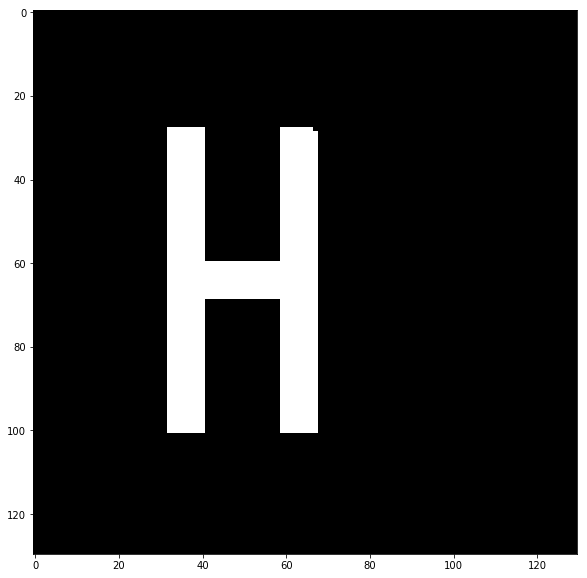

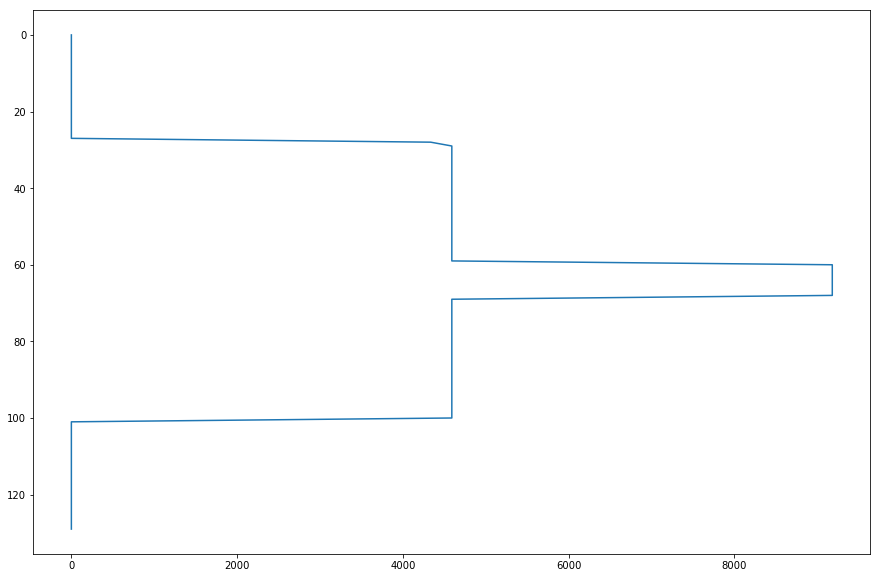

(1, 64, 64)


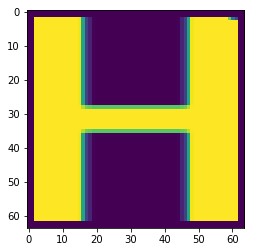

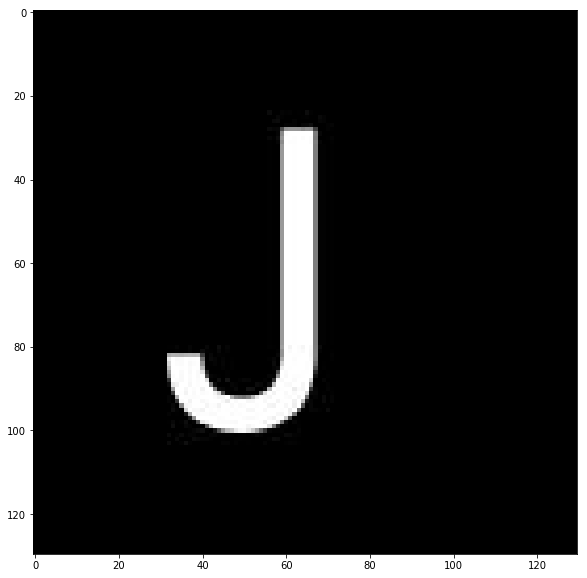

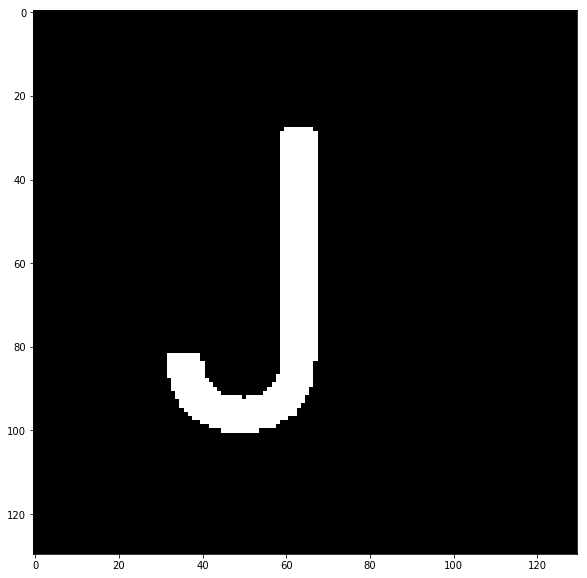

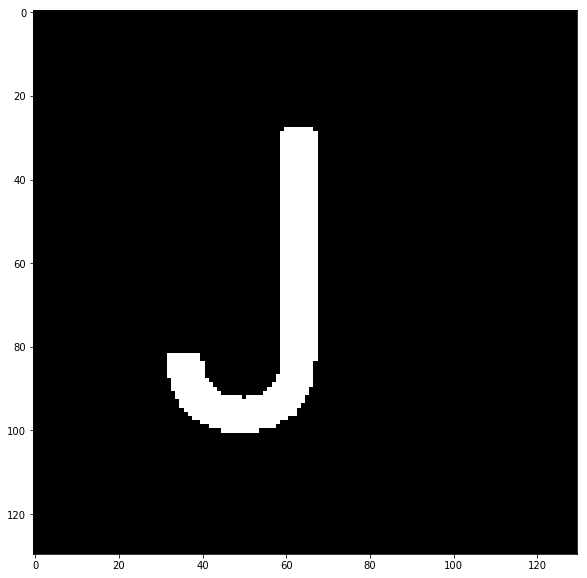

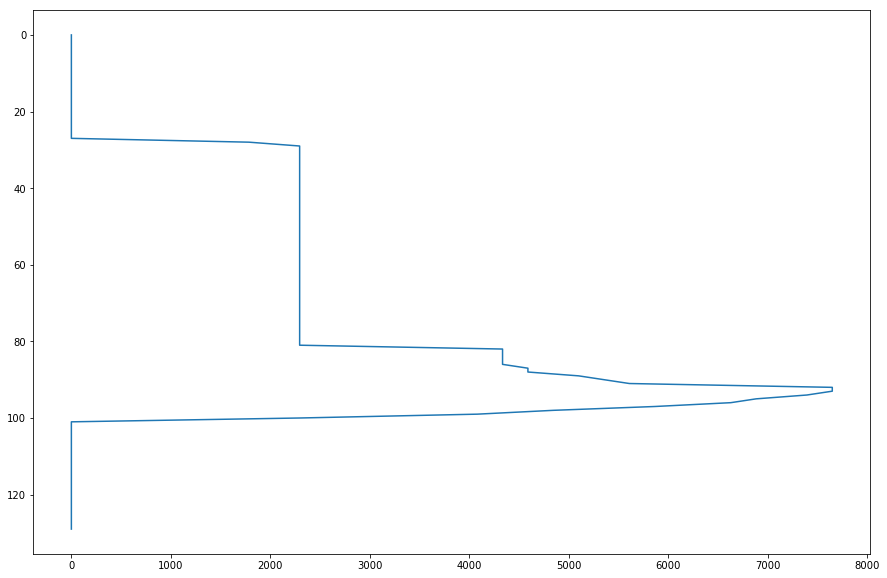

(1, 64, 64)


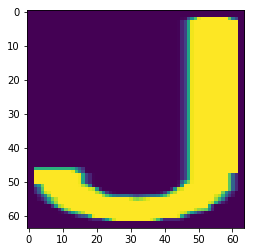

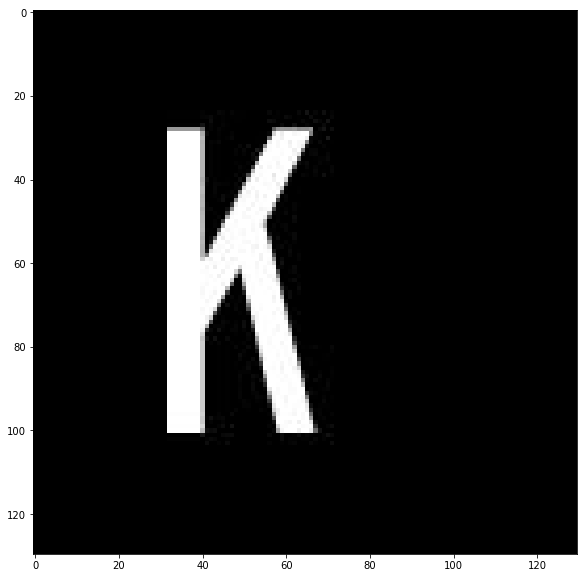

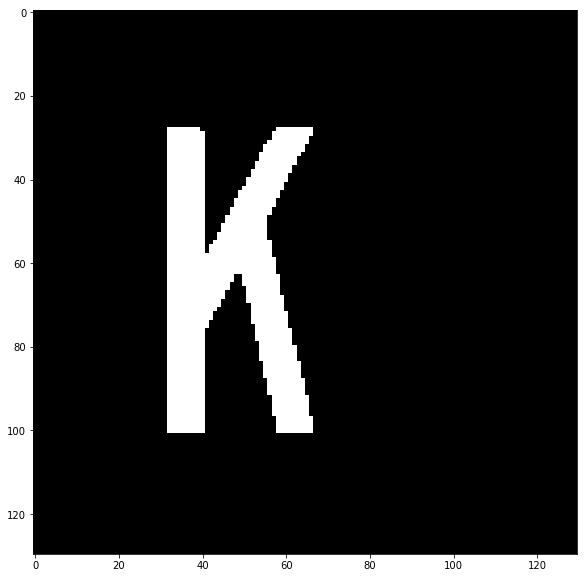

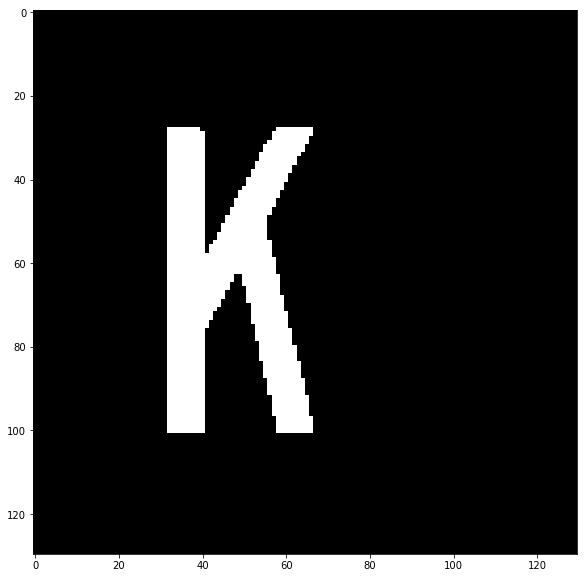

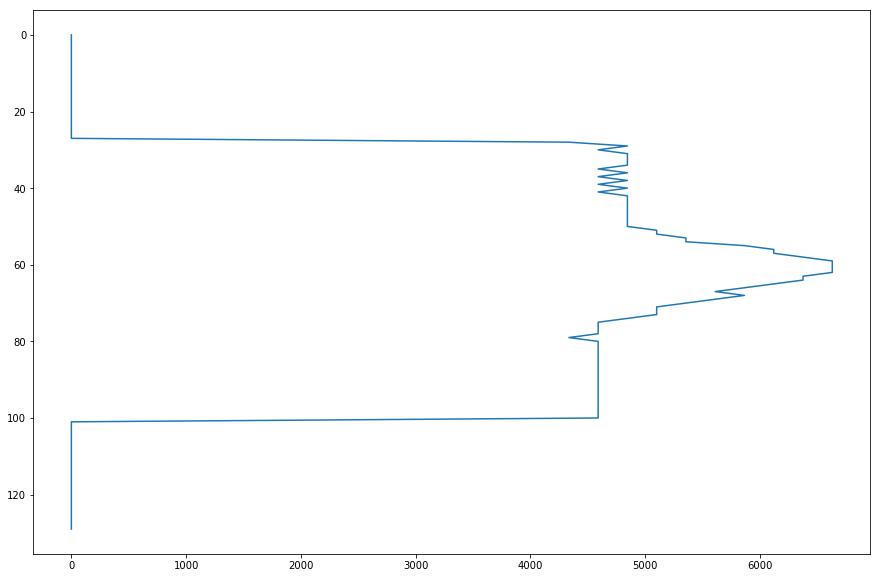

(1, 64, 64)


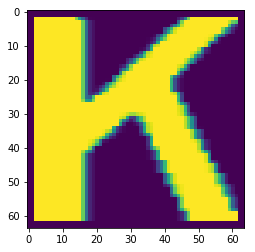

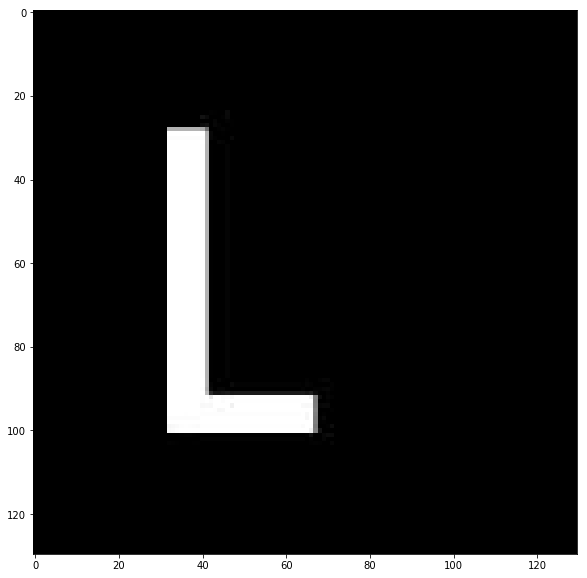

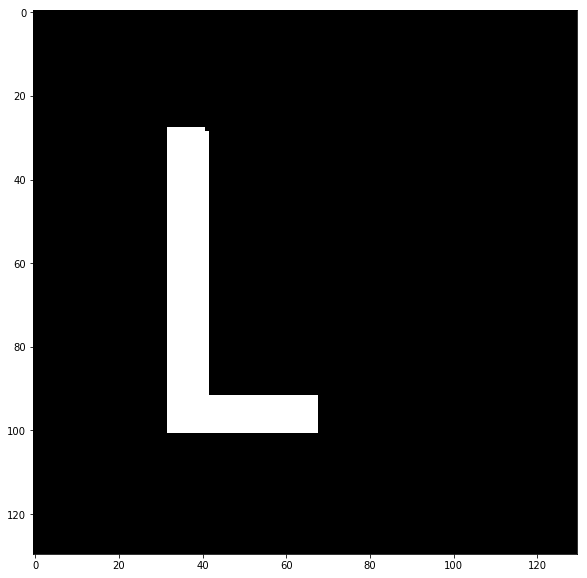

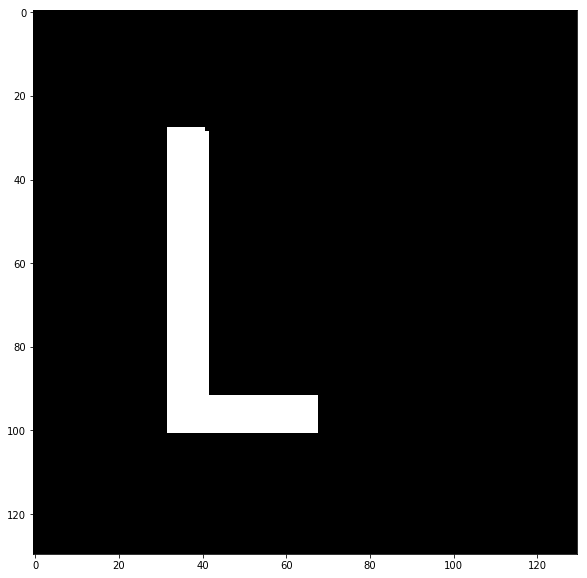

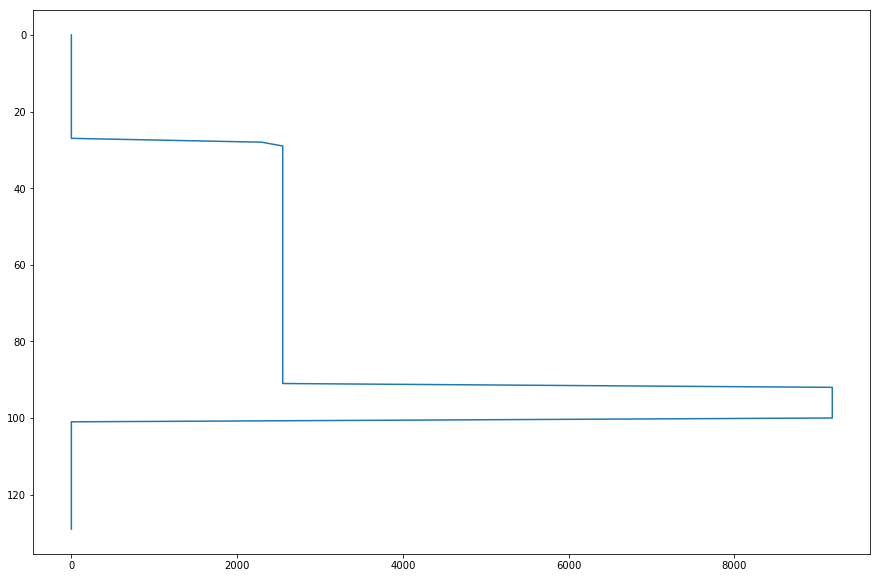

(1, 64, 64)


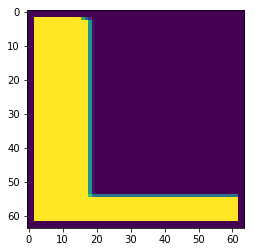

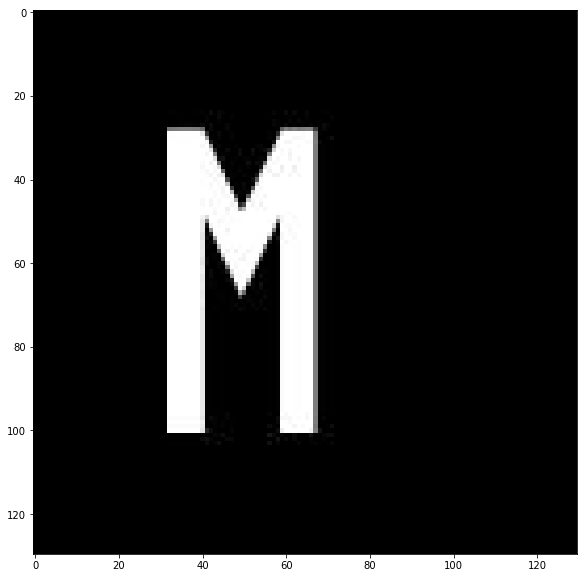

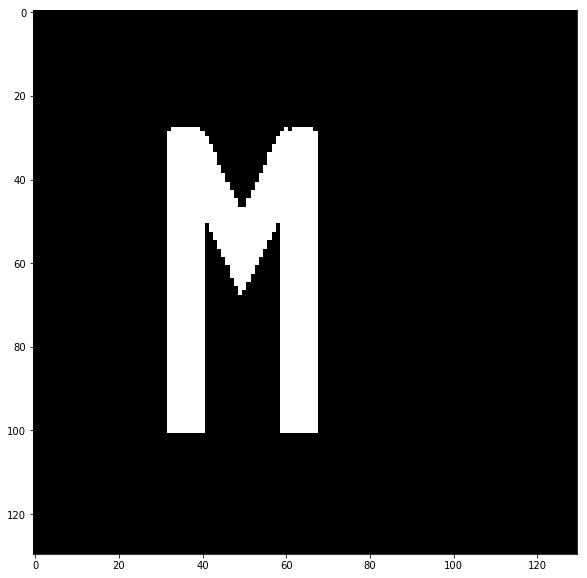

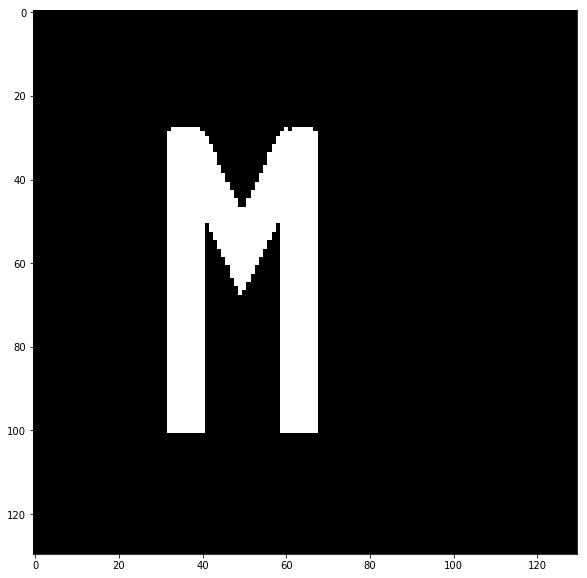

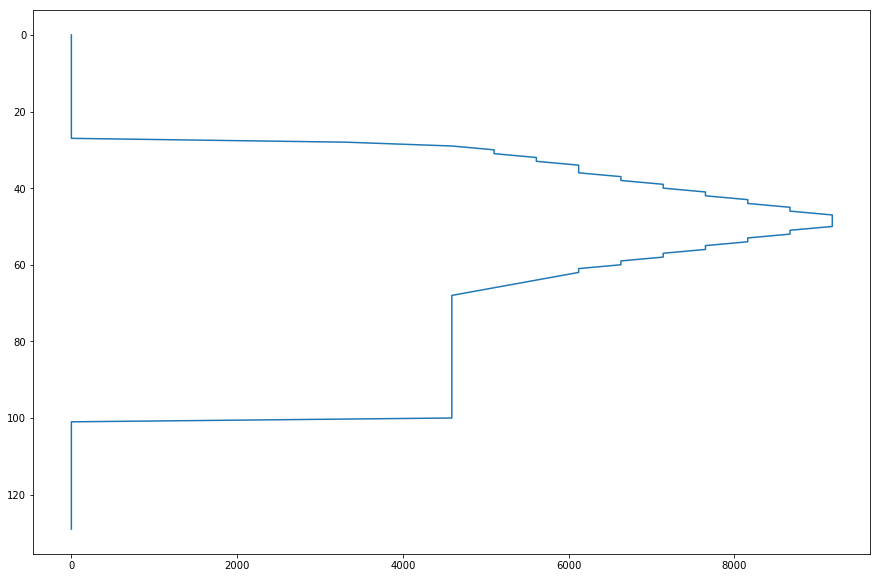

(1, 64, 64)


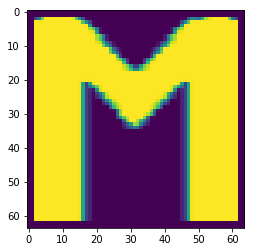

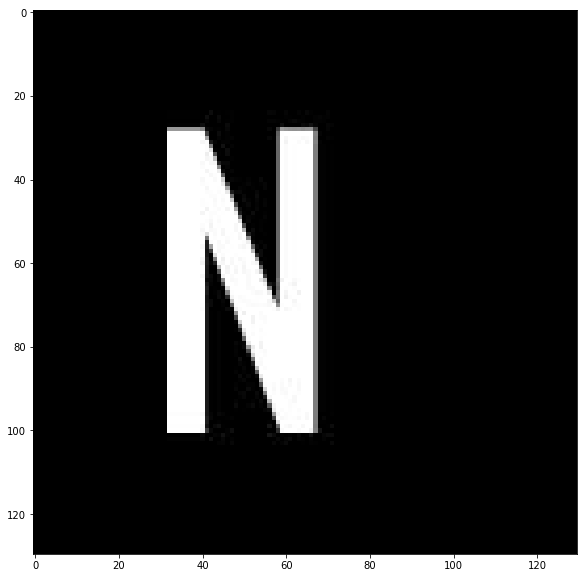

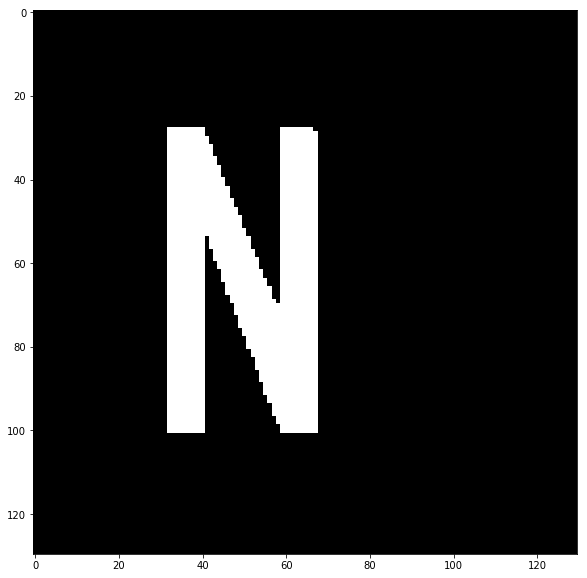

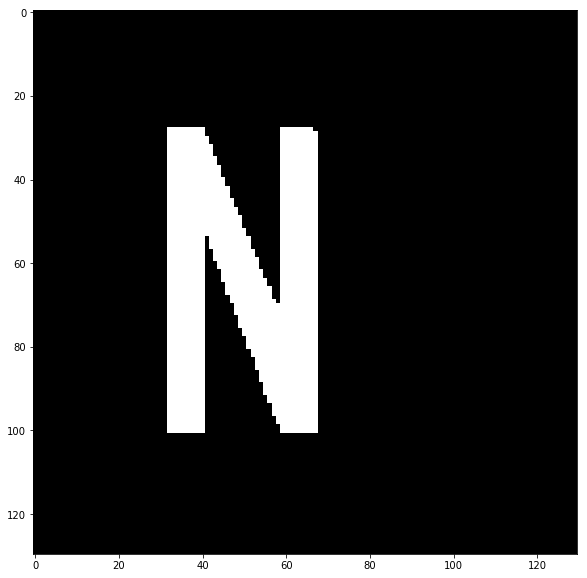

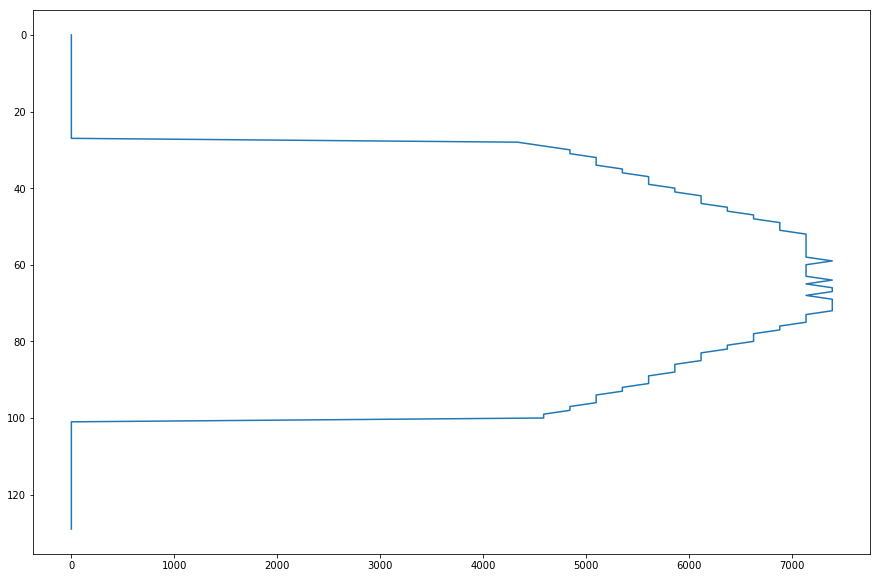

(1, 64, 64)


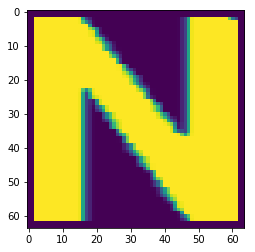

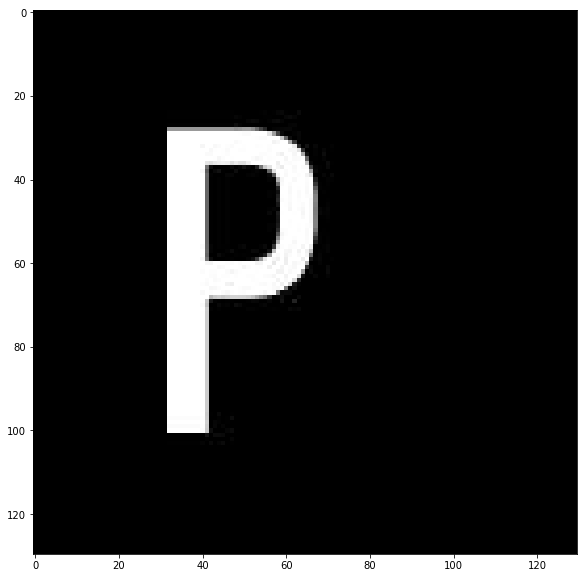

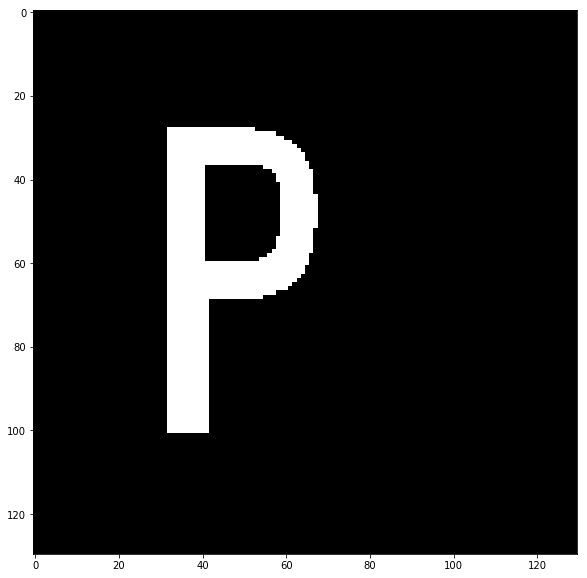

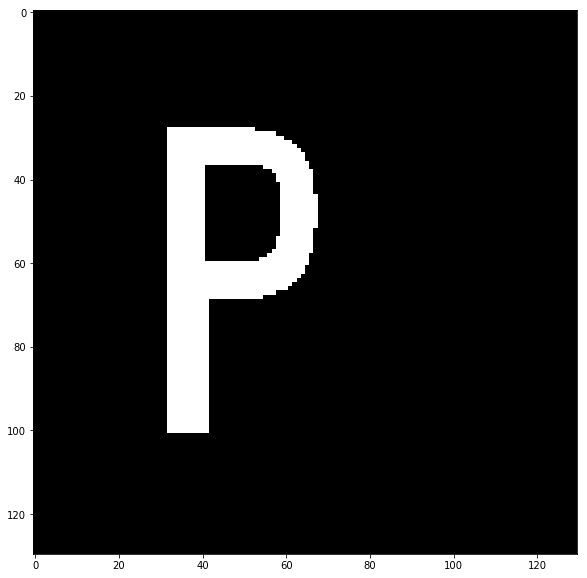

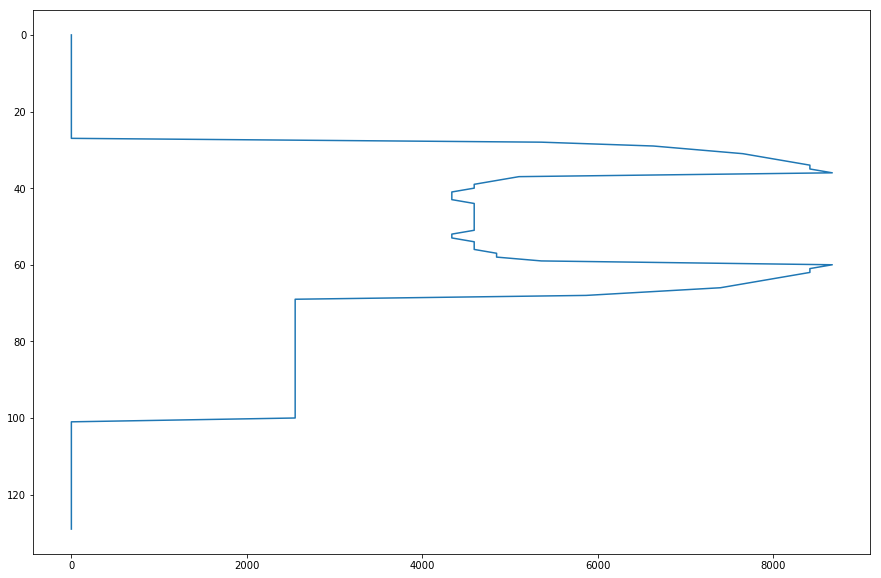

(1, 64, 64)


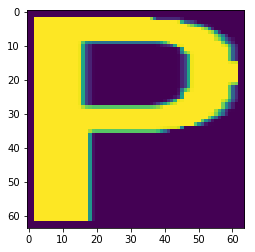

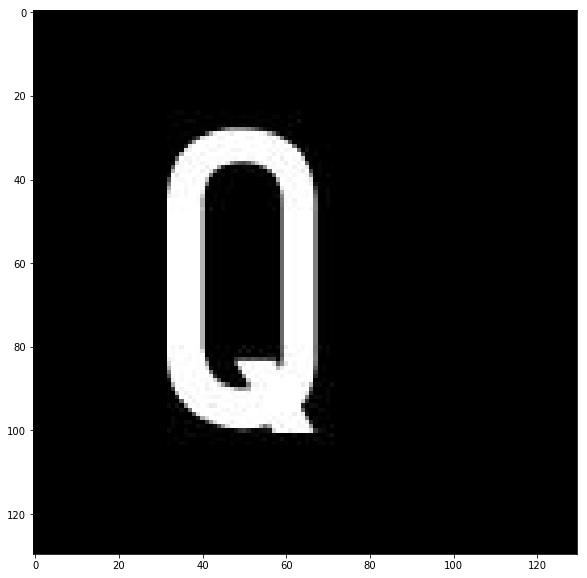

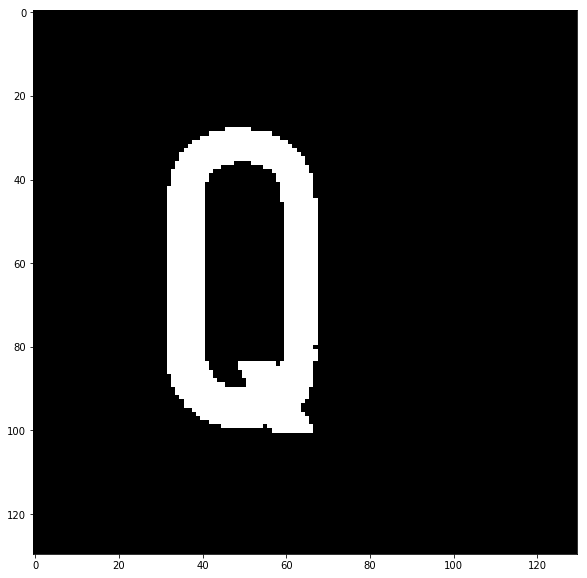

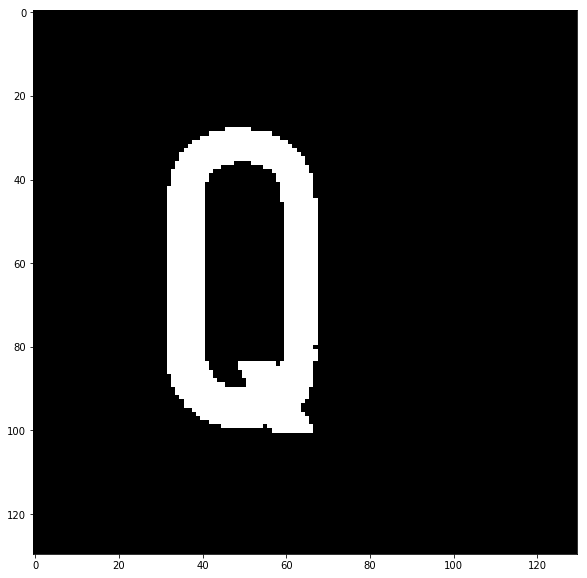

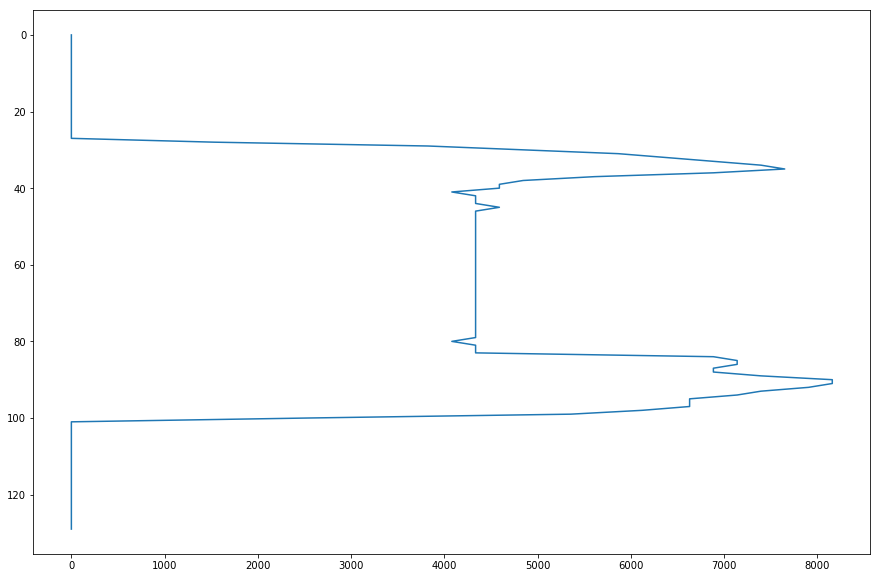

(1, 64, 64)


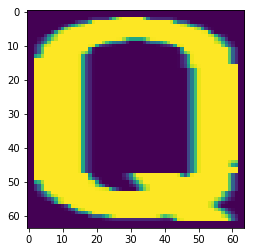

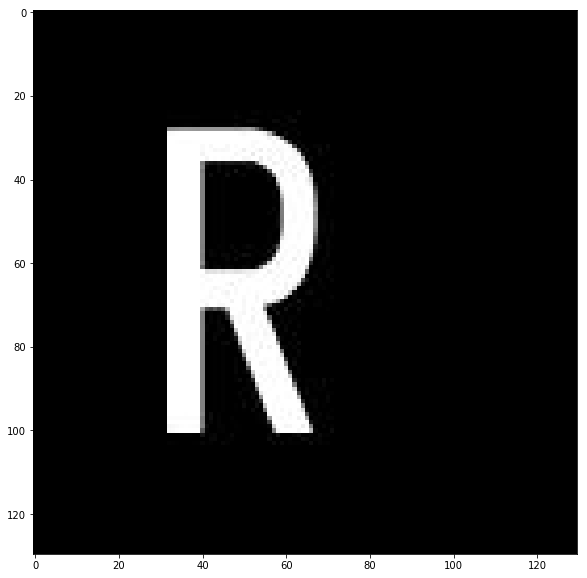

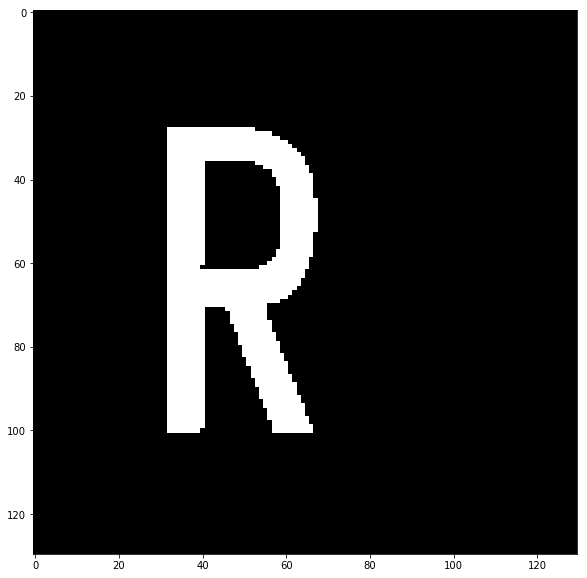

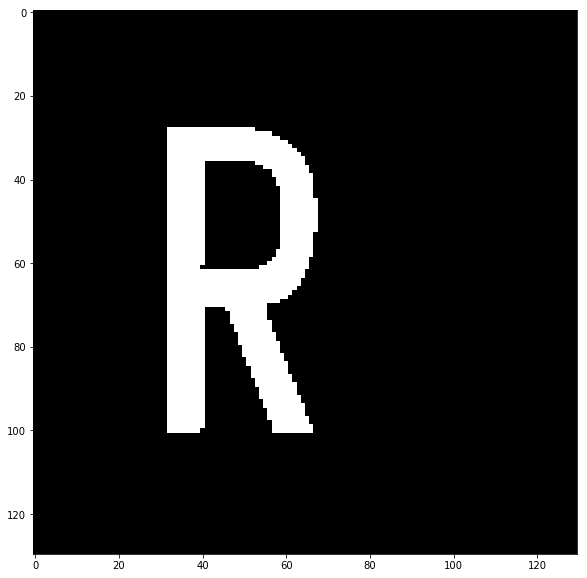

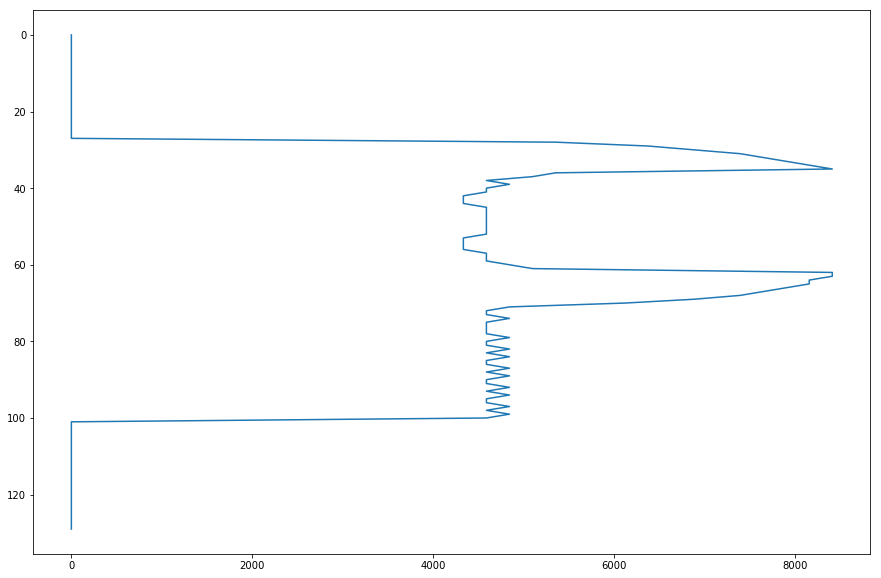

(1, 64, 64)


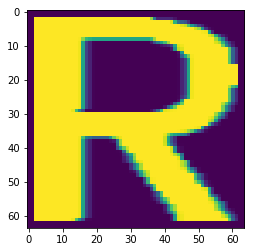

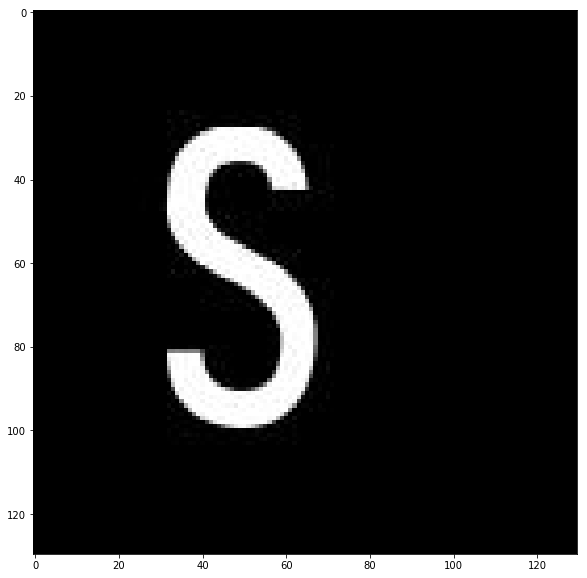

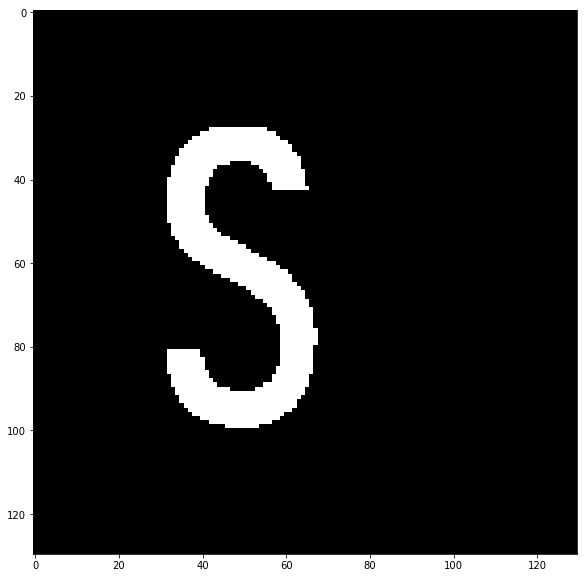

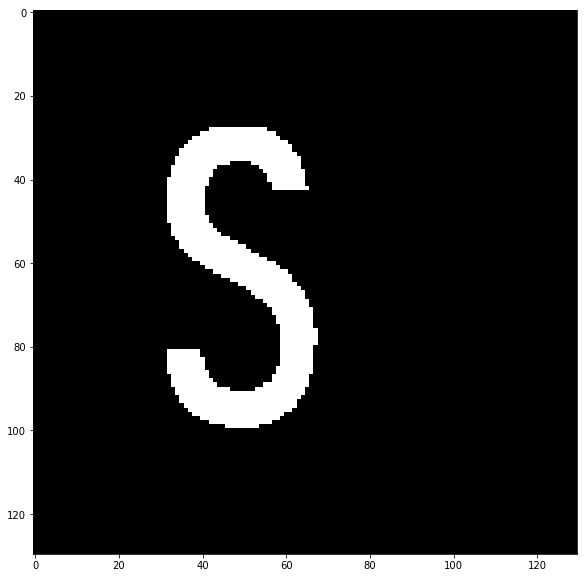

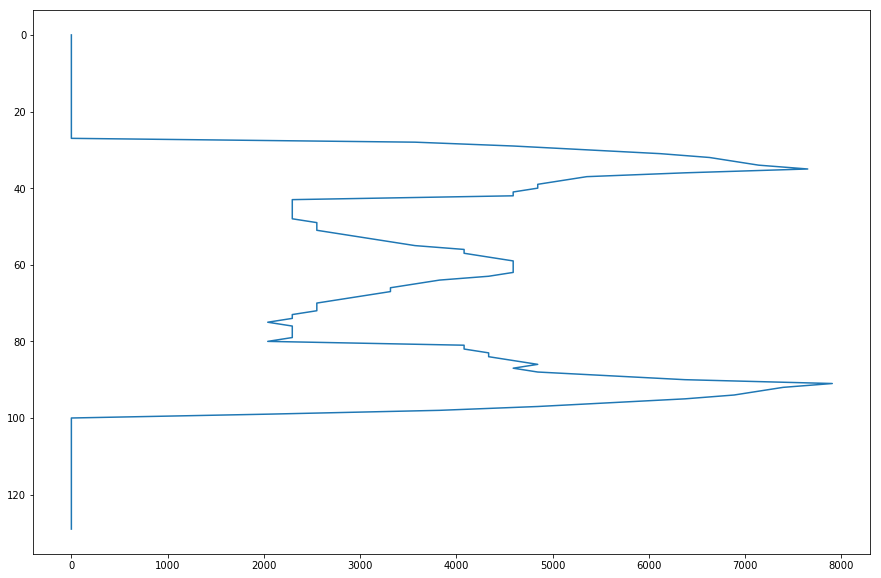

(1, 64, 64)


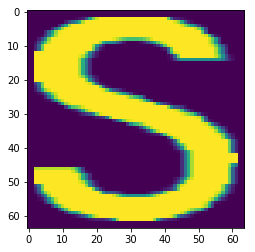

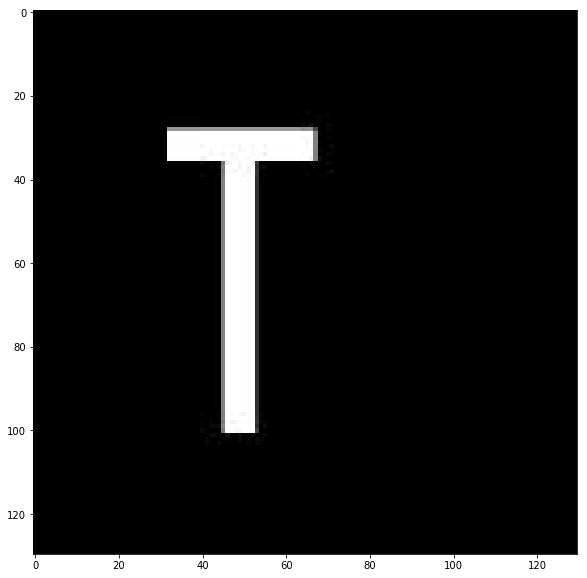

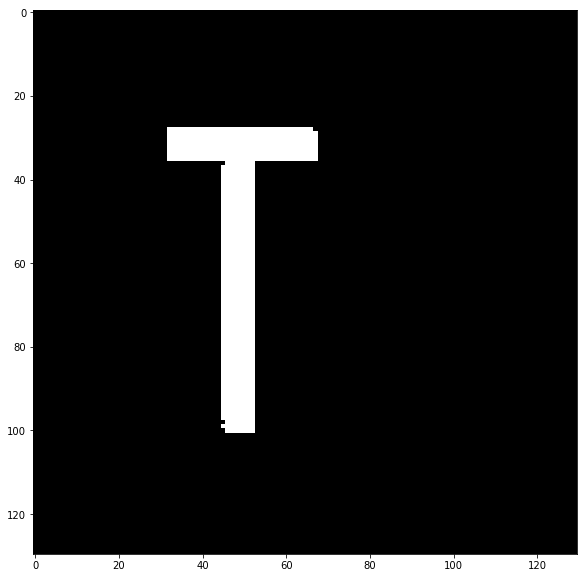

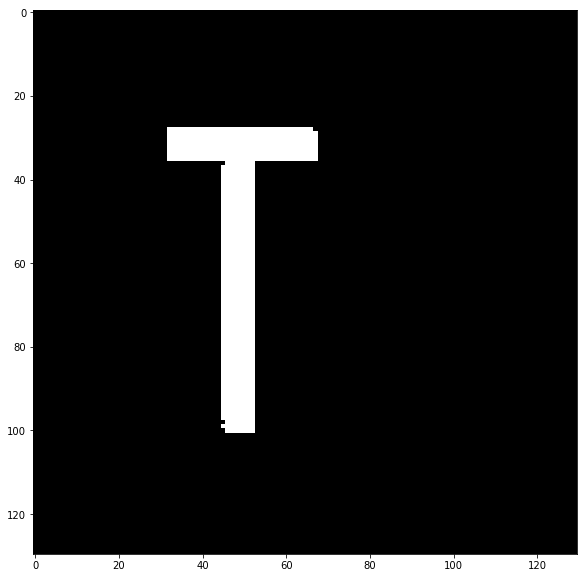

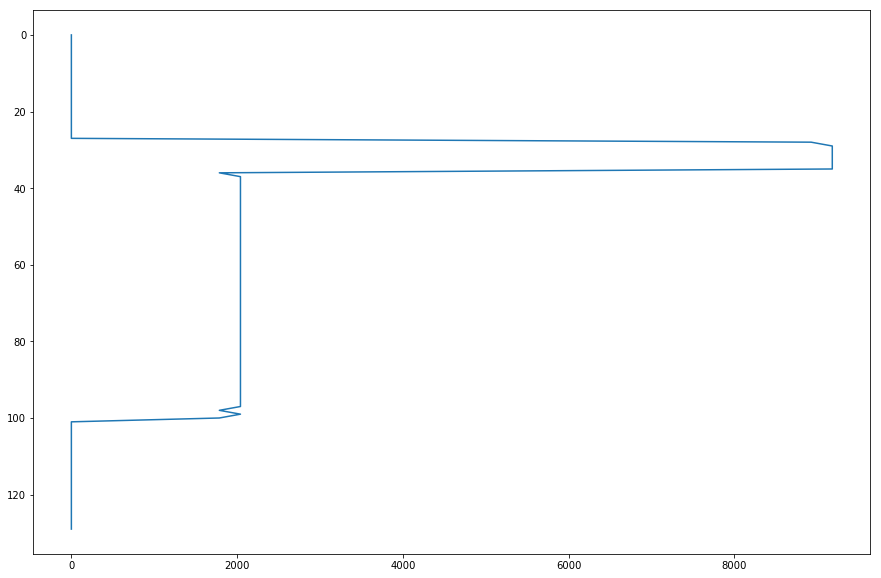

(1, 64, 64)


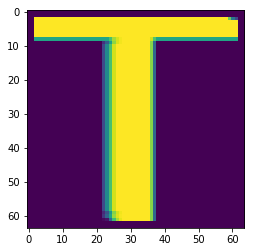

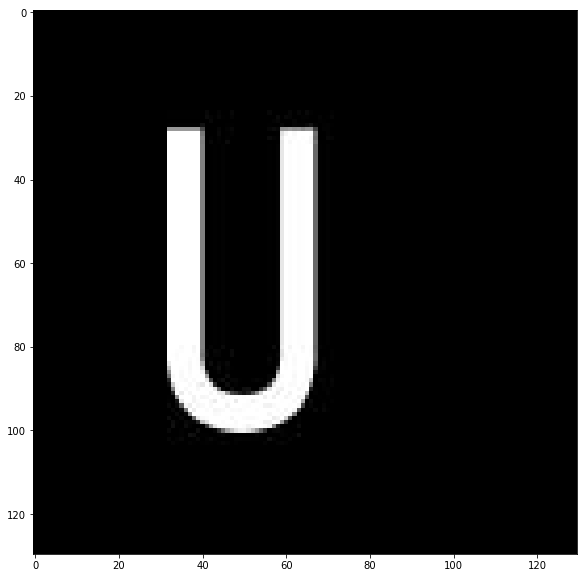

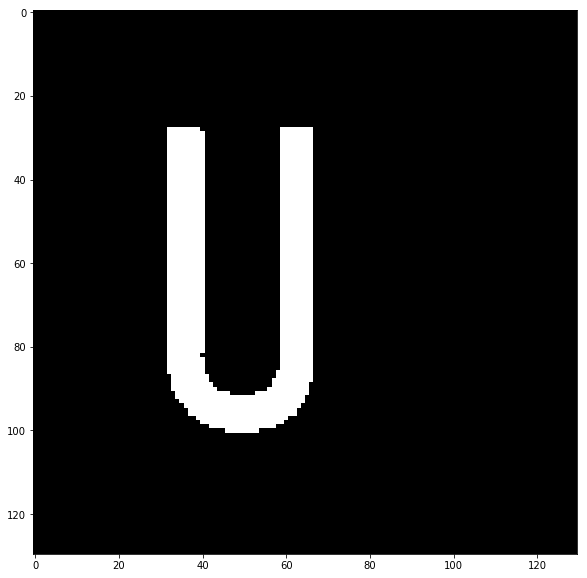

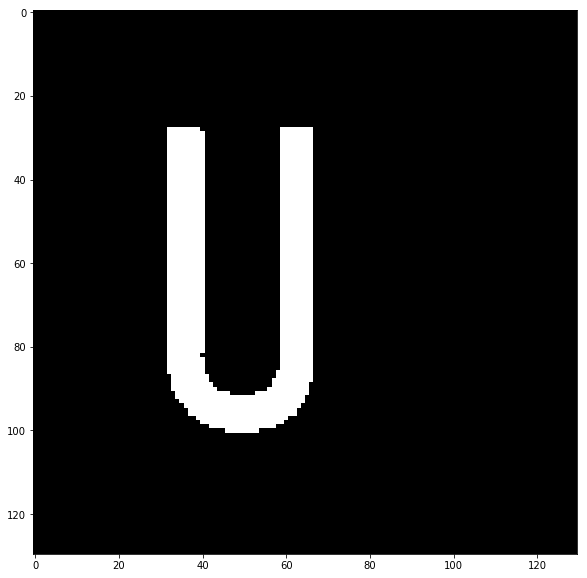

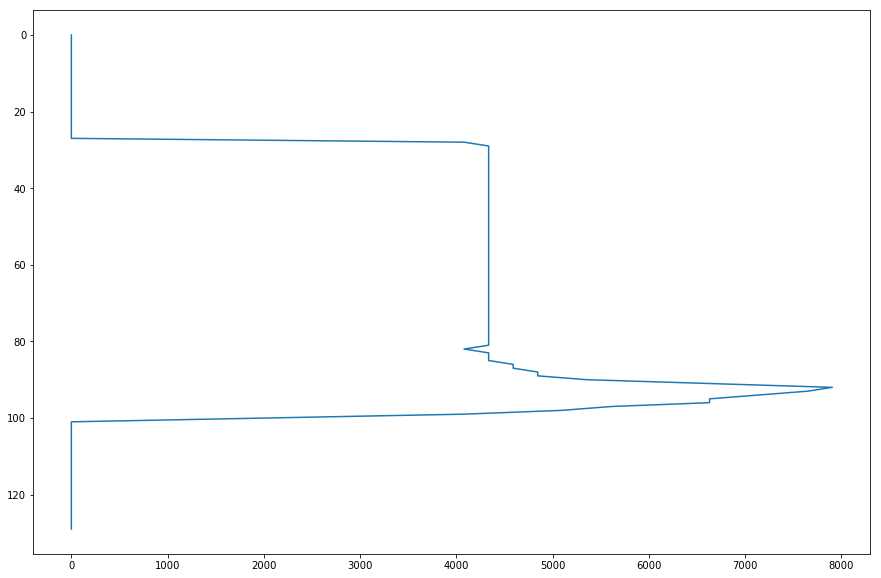

(1, 64, 64)


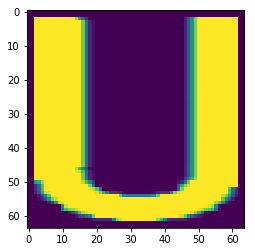

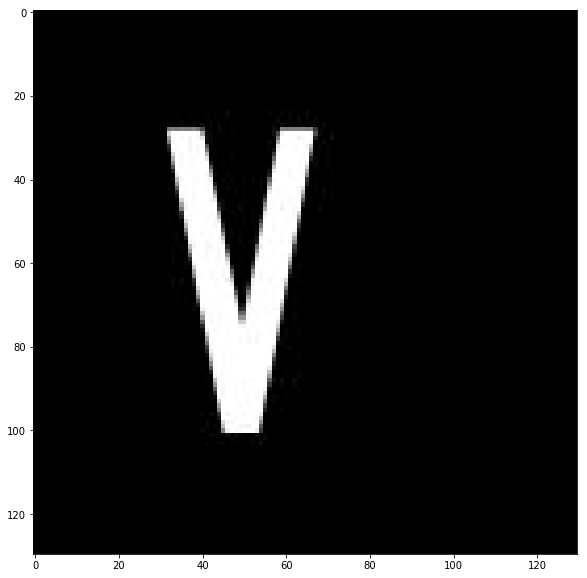

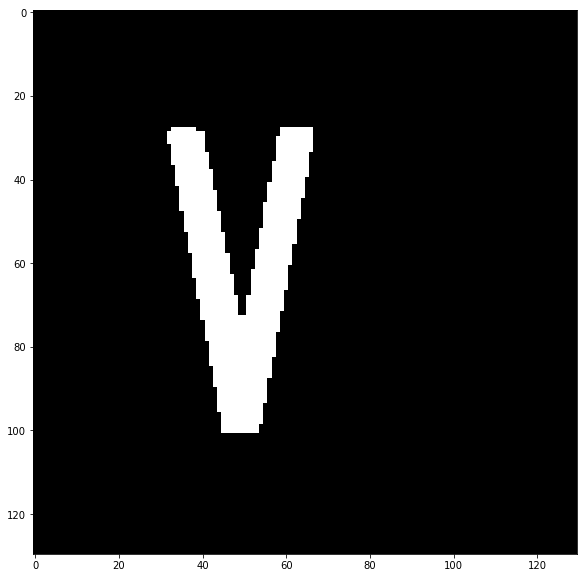

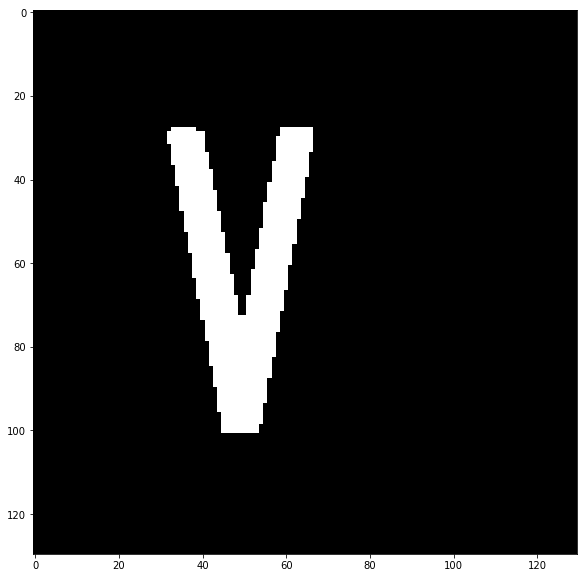

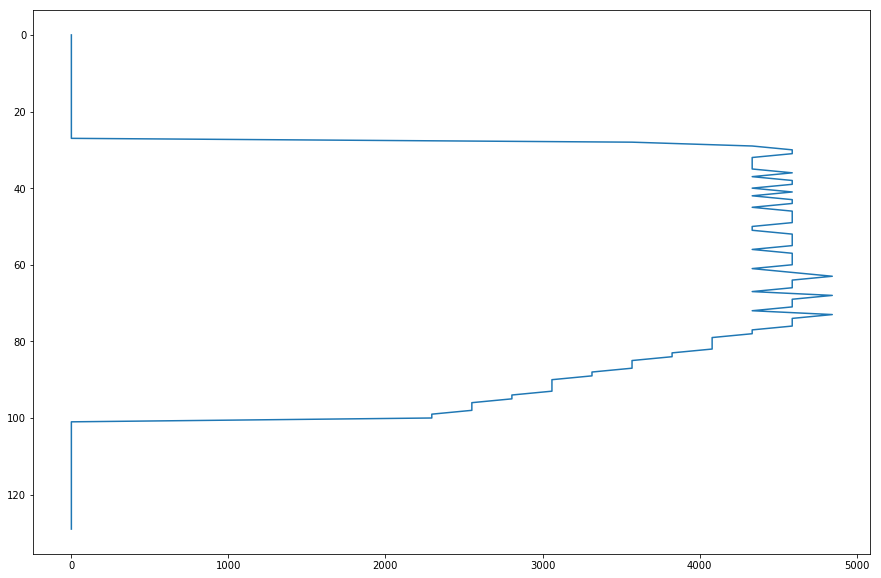

(1, 64, 64)


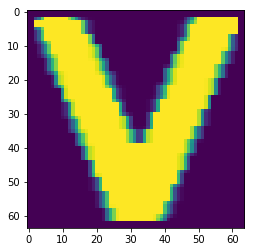

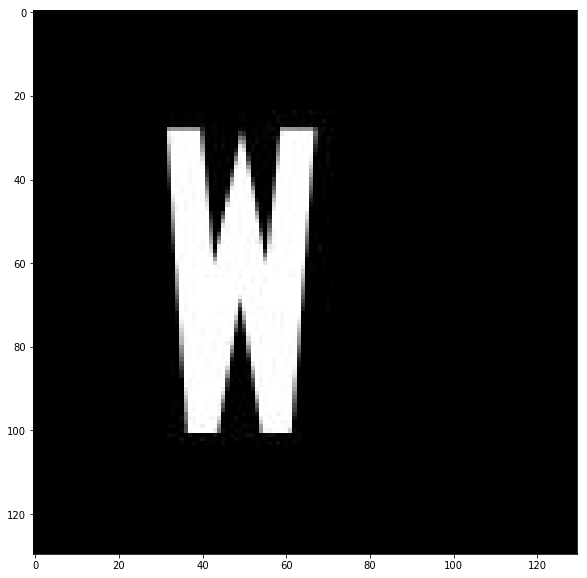

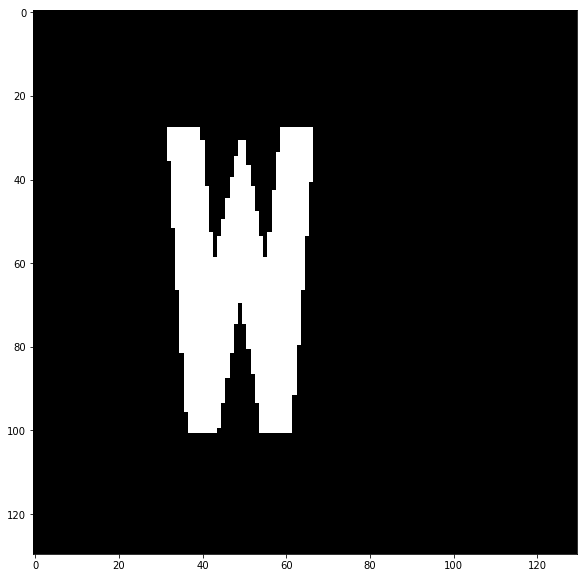

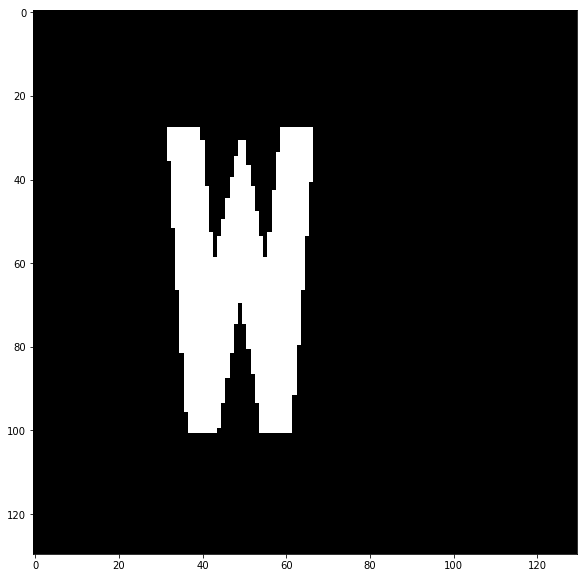

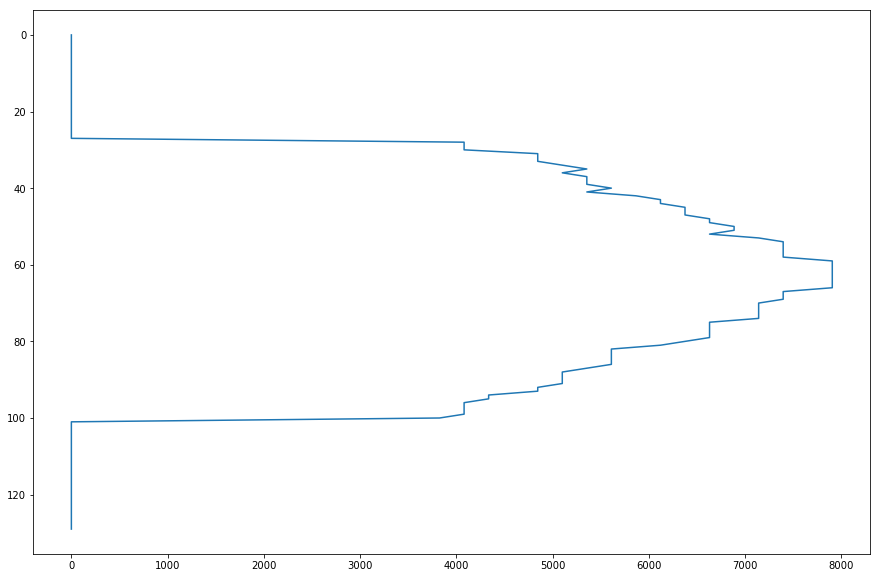

(1, 64, 64)


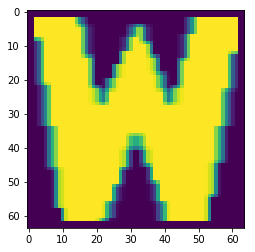

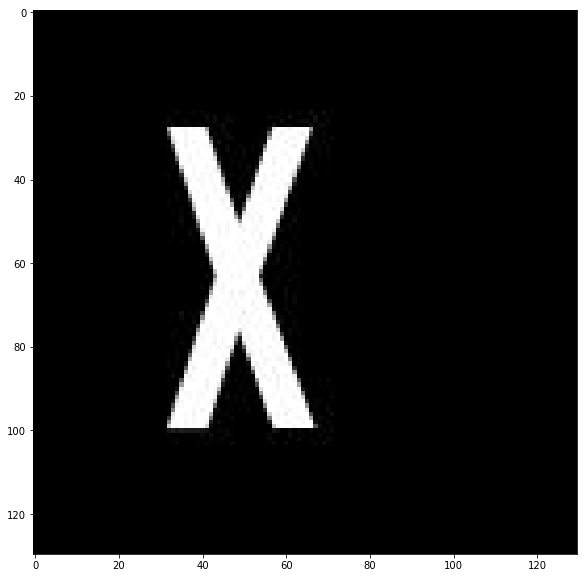

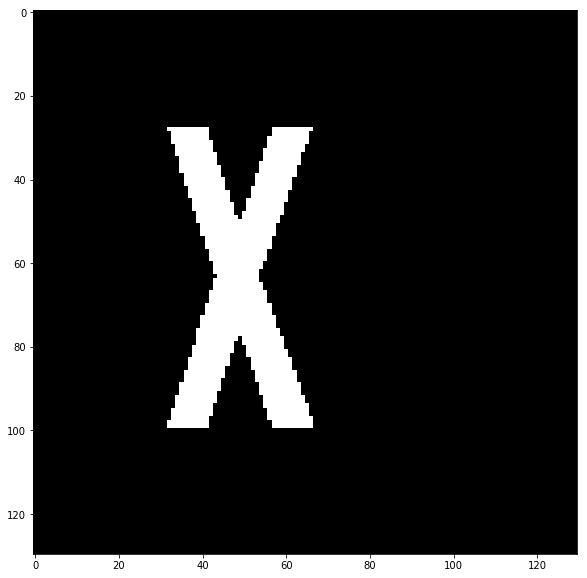

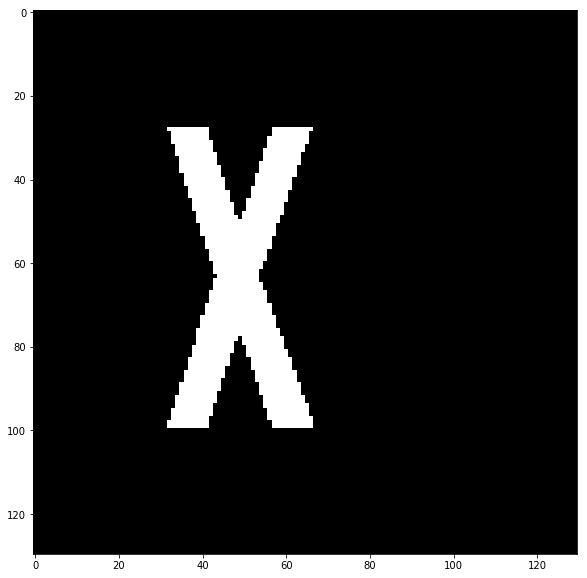

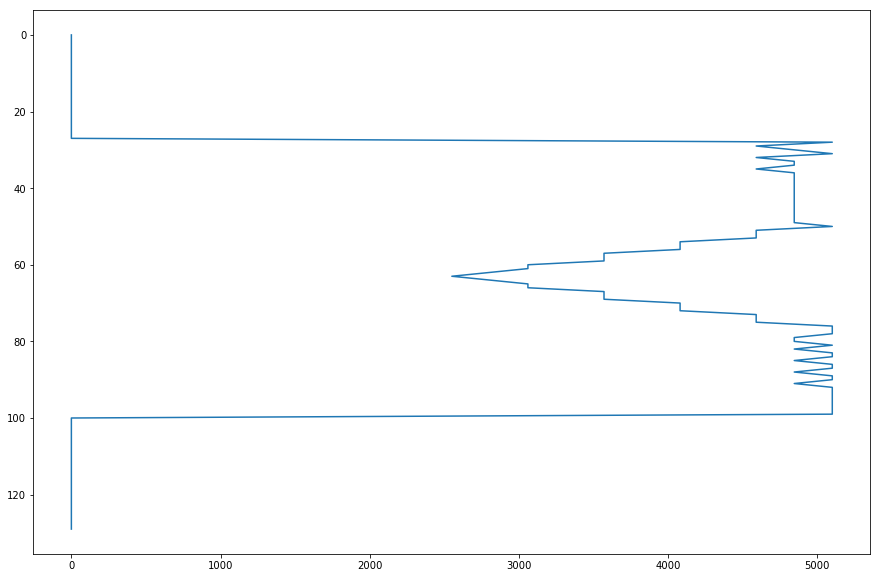

(1, 64, 64)


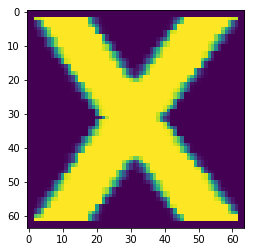

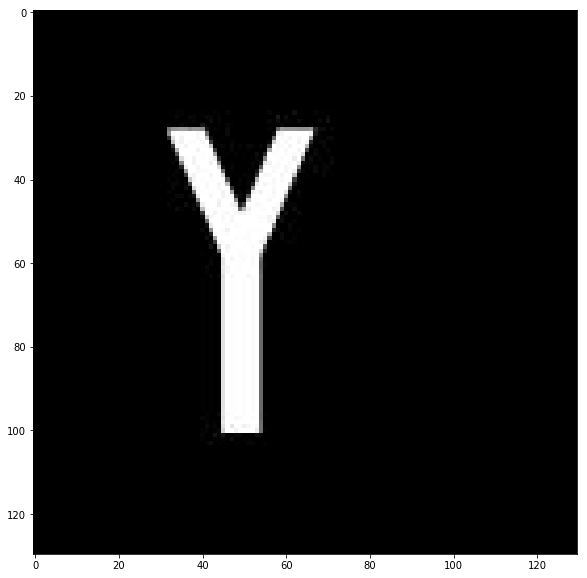

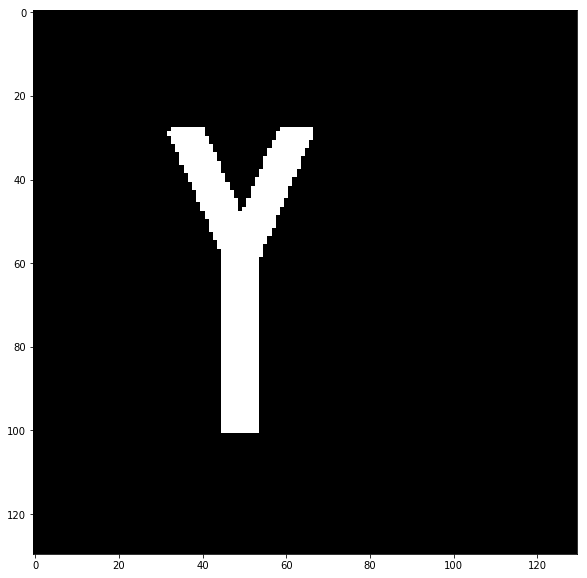

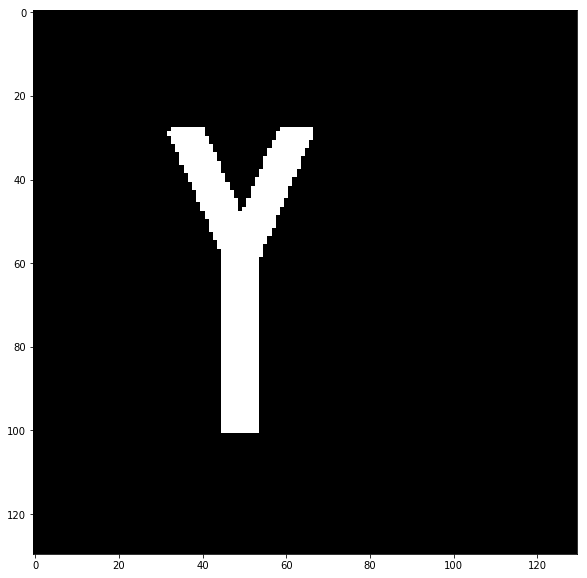

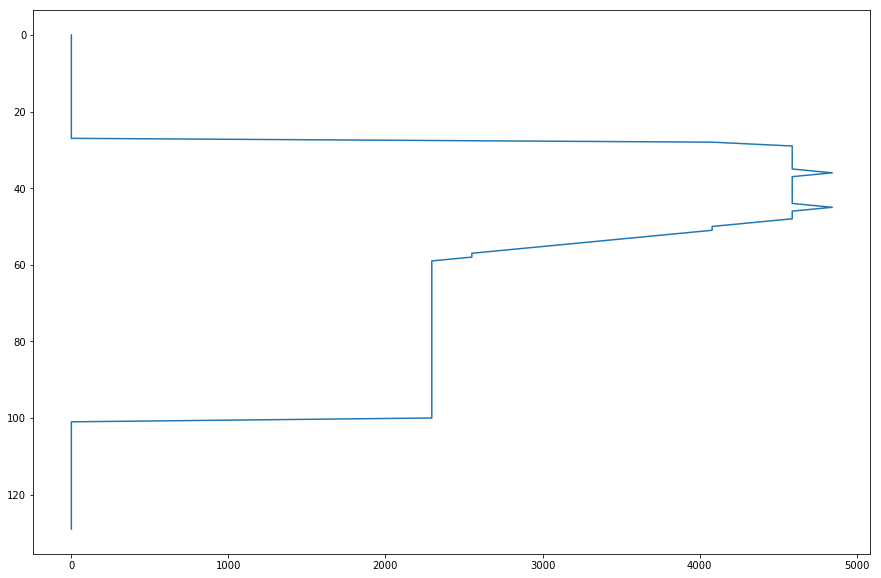

(1, 64, 64)


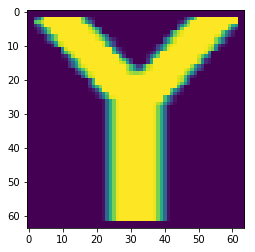

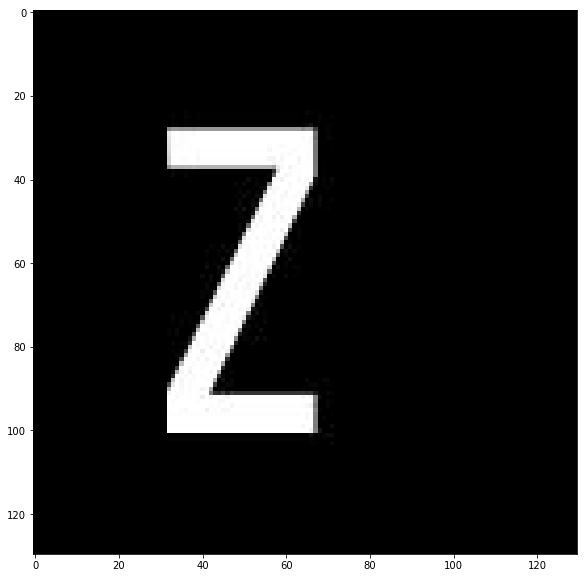

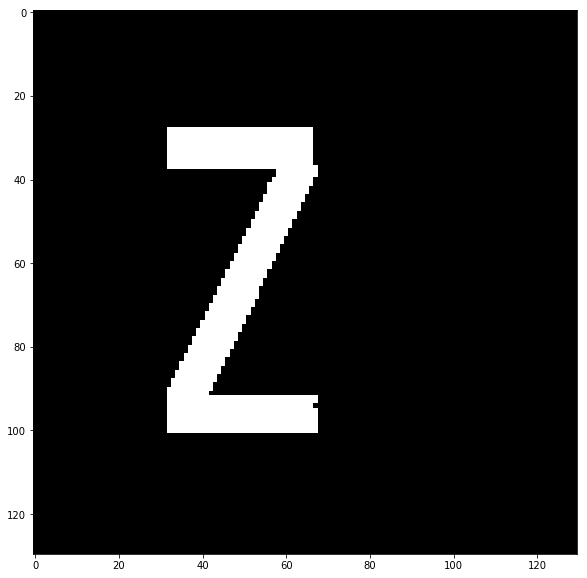

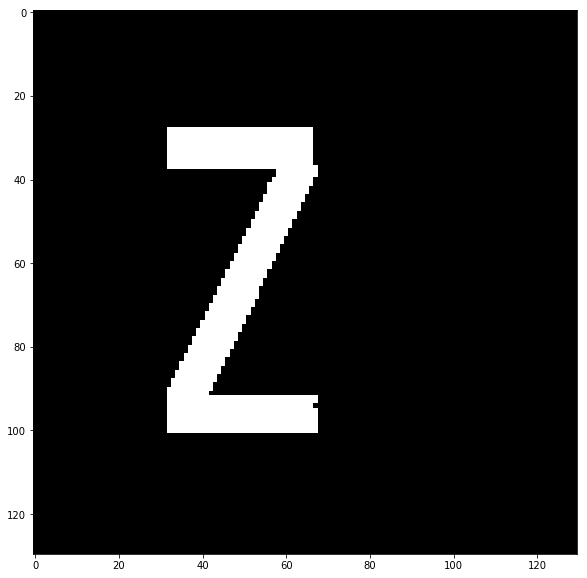

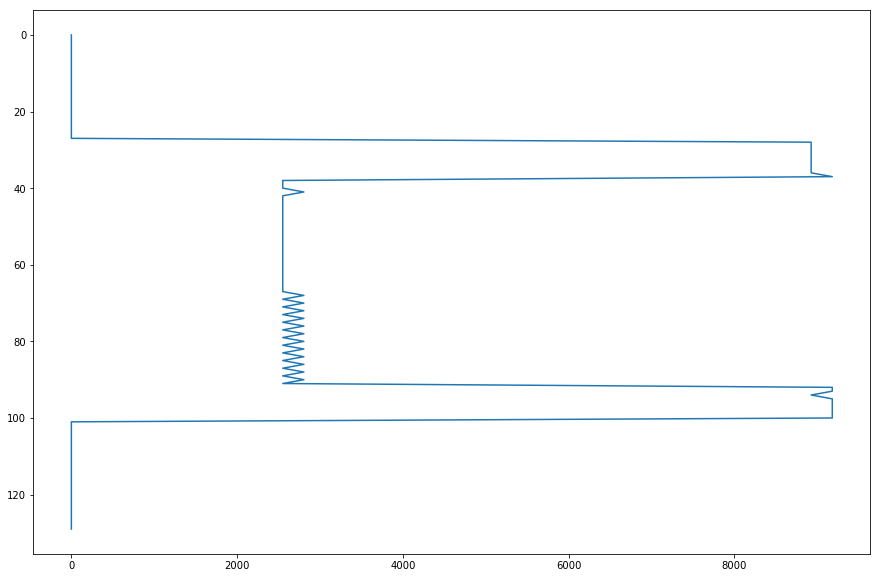

(1, 64, 64)


In [3]:
if __name__ == "__main__":
    #print(os.getcwd())
    norm_width = 64
    norm_height = 64
    base_path = '/workspace/plateRec/number/'
    crop_zeros = PreprocessCropZeros()
    resize_keep_ratio = PreprocessResizeKeepRatioFillBG(
                    norm_width, norm_height, fill_bg=False, margin=4)
    num = 34    
    for i in range(num):
        char_imgs = []
        image_path = base_path+'raw_images/'+str(i)+'.jpg'
        raw_color_img = plt.imread(image_path)
        gray_image = cv2.cvtColor(raw_color_img, cv2.COLOR_RGB2GRAY)
        plt.figure(figsize=(15,10))
        plt.imshow(gray_image, cmap='gray')
        _, adaptive_image = cv2.threshold(
            gray_image,
            120,
            255,\
            cv2.THRESH_BINARY)
        #print('adap',adaptive_image.shape)
        #adaptive_image = 255 - adaptive_image
        plt.figure(figsize=(15,10))
        plt.imshow(adaptive_image, cmap='gray')
    
        #adaptive_image = cv2.adaptiveThreshold(
         #   gray_image,
          #  255,
           # cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            #cv2.THRESH_BINARY, 11, 2)
        #adaptive_image = 255 - adaptive_image
        plt.figure(figsize=(15,10))
        plt.imshow(adaptive_image, cmap='gray')
        vertical_peek_ranges2d = []
        horizontal_sum = np.sum(adaptive_image, axis=1)
        #print(horizontal_sum)
        peek_ranges = extract_peek_ranges_from_array(horizontal_sum)
        # 直接切割
        vertical_peek_ranges2d = crop_direct(peek_ranges, debug = False)
        plt.figure(figsize=(15,10))
        plt.plot(horizontal_sum, range(horizontal_sum.shape[0]))
        plt.gca().invert_yaxis()  
        plt.show()

        for j, peek_range in enumerate(peek_ranges):
            for vertical_range in vertical_peek_ranges2d[j]:
                x = vertical_range[0]
                y = peek_range[0]
                w = vertical_range[1] - x
                h = peek_range[1] - y
                char_img = adaptive_image[y:y+h+1, x:x+w+1]
                char_img = crop_zeros.do(char_img)
                char_img = resize_keep_ratio.do(char_img)
                char_imgs.append(char_img)
                
        np_char_imgs = np.asarray(char_imgs)
        
        print(np_char_imgs.shape)
        np_image = np_char_imgs.reshape(64,64)
        plt.imshow(np_image)
        pil_im2 = Image.fromarray(np_image)
        os.mkdir(base_path+'images/'+str(i))
        pil_im2.save(base_path+'images/'+str(i)+'/0.jpg','JPEG')